<a href="https://colab.research.google.com/github/Bealph/Projet3_dwj_OPC/blob/main/p7_note_methodologique_122023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>># **PROJET : Implémentez un modèle de scoring**

>>>Source du jeu de données : https://www.kaggle.com/c/home-credit-default-risk/data

>>> __Lien vers les kernels Kaggle selectionnés__

* [Manual Feature Engineering Part One](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering)

# **Introduction : Infos et explications**

## Home Credit Default Risk Competition

Dans ce notebook, nous allons jeter un premier coup d'œil à la compétition d'apprentissage automatique sur le risque de défaut de Home Credit, actuellement hébergée sur Kaggle. L'objectif de ce concours est d'utiliser les données historiques des demandes de prêt pour prédire si un demandeur sera en mesure de rembourser un prêt. Il s'agit d'une tâche standard de classification supervisée :

* __Supervisé__: les labels sont incluses dans les données d'entraînement et l'objectif est d'entraîner un modèle qui apprend à prédire les labels à partir des caractéristiques.
* __Classification__: Le label est une variable binaire, 0 (remboursera le prêt à temps), 1 (aura des difficultés à rembourser le prêt).



## Data

Les données sont fournies par [Home Credit] (http://www.homecredit.net/about-us.aspx), un service dédié à la fourniture de lignes de crédit (prêts) à la population non bancarisée. Prédire si un client remboursera ou non un prêt ou s'il rencontrera des difficultés est un besoin commercial essentiel.

Il existe 7 sources de données différentes :

* **application_train**/**application_test** : les données principales d'entraînement et de test avec des informations sur chaque demande de prêt chez Home Credit. Chaque prêt a sa propre ligne et est identifié par la caractéristique `SK_ID_CURR`. Les données de la demande d'entraînement sont accompagnées de la caractéristique `TARGET` indiquant 0 : le prêt a été remboursé ou 1 : le prêt n'a pas été remboursé.
* **bureau** : données concernant les crédits antérieurs du client auprès d'autres institutions financières. Chaque crédit antérieur a sa propre ligne dans le bureau, mais un prêt dans les données de la demande peut avoir plusieurs crédits antérieurs.
* **bureau_balance** : données mensuelles concernant les crédits antérieurs dans bureau. Chaque ligne correspond à un mois d'un crédit antérieur, et un seul crédit antérieur peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit.
* **previous_application** : demandes antérieures de prêts auprès de Home Credit pour les clients qui ont des prêts dans les données de demande. Chaque prêt en cours dans les données de la demande peut avoir plusieurs prêts antérieurs. Chaque demande précédente a une ligne et est identifiée par la caractéristique `SK_ID_PREV`.
* **POS_CASH_BALANCE** : données mensuelles sur les prêts au point de vente ou les prêts au comptant que les clients ont eus avec Home Credit. Chaque ligne correspond à un mois d'un prêt au point de vente ou d'un prêt au comptant antérieur, et un seul prêt antérieur peut avoir plusieurs lignes.
* **credit_card_balance** : données mensuelles sur les cartes de crédit que les clients ont déjà eues avec Home Credit. Chaque ligne correspond à un mois de solde de carte de crédit, et une seule carte de crédit peut avoir plusieurs lignes.
* **installments_payment** : historique des paiements pour les prêts précédents chez Home Credit. Il y a une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué.

Ce diagramme montre comment toutes les données sont liées :

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

De plus, on nous fournit les définitions de toutes les colonnes (dans `HomeCredit_columns_description.csv`) et un exemple du fichier de soumission attendu.

Dans ce notebook, nous nous en tiendrons à utiliser uniquement les données de formation et de test de l'application principale. Bien que nous devions utiliser toutes les données si nous voulions avoir un espoir de participer sérieusement à la compétition, nous nous en tiendrons pour l'instant à un seul fichier, ce qui devrait être plus facile à gérer. Cela nous permettra d'établir une base de référence que nous pourrons ensuite améliorer. Dans ce genre de projet, il est préférable de comprendre le problème petit à petit plutôt que de s'y plonger complètement et de s'y perdre !

### Metric: ROC AUC

Une fois que nous avons compris les données (la lecture des [descriptions des colonnes](https://www.kaggle.com/c/home-credit-default-risk/data) nous aide énormément), nous devons comprendre la mesure par laquelle notre soumission est jugée. Dans le cas présent, il s'agit d'une mesure de classification courante connue sous le nom de [Surface sous la courbe de la caractéristique d'exploitation du récepteur (ROC AUC, parfois appelée AUROC)] (https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it).

L'aire sous la courbe ROC peut sembler intimidante, mais elle est relativement simple une fois que l'on a assimilé les deux concepts individuels. La [courbe ROC (Reciever Operating Characteristic)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) représente graphiquement le taux de vrais positifs par rapport au taux de faux positifs :

![image](http://www.statisticshowto.com/wp-content/uploads/2016/08/ROC-curve.png)

Une seule ligne sur le graphique indique la courbe pour un seul modèle, et le déplacement le long d'une ligne indique le changement du seuil utilisé pour classer une instance positive. Le seuil commence à 0 en haut à droite et va jusqu'à 1 en bas à gauche. Une courbe située à gauche et au-dessus d'une autre courbe indique un meilleur modèle. Par exemple, le modèle bleu est meilleur que le modèle rouge, qui est meilleur que la ligne diagonale noire qui indique un modèle de devinettes aléatoires naïves.

La [Surface sous la courbe (SSC)] (http://gim.unmc.edu/dxtests/roc3.htm) s'explique d'elle-même par son nom ! Il s'agit simplement de l'aire sous la courbe ROC. (Cette mesure est comprise entre 0 et 1, un meilleur modèle obtenant un score plus élevé. Un modèle qui se contente de deviner au hasard aura une aire sous la courbe ROC de 0,5.

Lorsque nous mesurons un classificateur en fonction de l'AUC ROC, nous ne générons pas des prédictions 0 ou 1, mais plutôt une probabilité entre 0 et 1. Cela peut être déroutant car nous aimons généralement penser en termes de précision, mais lorsque nous rencontrons des problèmes avec des classes déséquilibrées (nous verrons que c'est le cas), la précision n'est pas la meilleure métrique. Par exemple, si je voulais construire un modèle capable de détecter les terroristes avec une précision de 99,9999 %, je me contenterais de créer un modèle prédisant que chaque personne n'est pas un terroriste. Il est clair que cela ne serait pas efficace (le rappel serait nul) et nous utilisons des mesures plus avancées telles que l'AUC ROC ou le [score F1] (https://en.wikipedia.org/wiki/F1_score) pour refléter plus précisément les performances d'un classificateur. Un modèle ayant un ROC AUC élevé aura également une précision élevée, mais le [ROC AUC est une meilleure représentation de la performance du modèle](https://datascience.stackexchange.com/questions/806/advantages-of-auc-vs-standard-accuracy).

Maintenant que nous connaissons le contexte des données que nous utilisons et la métrique à maximiser, commençons à explorer les données.

Dans ce notebook, comme indiqué précédemment, nous nous en tiendrons aux principales sources de données et aux modèles simples sur lesquels nous pourrons nous appuyer à l'avenir.

# Imports librairies

In [ ]:
# numpy et pandas pour la manipulation des données
import numpy as np
import pandas as pd

# prétraitement pour les variables catégorielles
from sklearn.preprocessing import LabelEncoder

# Gestion du système de fichiers
import os

# Supprimer les avertissements
import warnings
warnings.filterwarnings('ignore')

# matplotlib et seaborn pour les tracés
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import pickle

Reglages de quelques paramètres

In [ ]:
#Formatons les colonnes en faisant en sorte que tous les décimaux soit affichés avec 3 chiffres après la virgule
pd.set_option('display.float_format', '{:.3f}'.format)

# Change les parametre de panda pour afficher toutes colonnes
pd.set_option('display.max_columns', None)

# Chargement des données
Tout d'abord, nous pouvons dresser la liste de tous les fichiers de données disponibles. Il y a au total 9 fichiers : 1 fichier principal pour la formation (avec la cible), 1 fichier principal pour le test (sans la cible), 1 fichier de soumission d'exemple et 6 autres fichiers contenant des informations supplémentaires sur chaque prêt.

In [ ]:
# Training data
app_train = pd.read_csv('application_train.csv')
print('Training data shape: ', app_train.shape)
print( )
app_train.head()

Training data shape:  (307511, 122)



SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0        202500.000  406597.500    24700.500   
1               N             0        270000.000 1293502.500    35698.500   
2               Y             0         67500.000  135000.000     6750.000   
3               Y             0        135000.000  312682.500    29686.500   
4               Y             0        121500.000  513000.000    21865.500   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0       351000.000   Unaccompanied          Working   
1      1129500.000          Family    State servant   
2       135000.000   Unaccompanied          Working   
3       297000.000   Unaccompanied          Working   
4       513000.000   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                       0.019       -9461           -637          -3648.000   
1                       0.004      -16765          -1188          -1186.000   
2                       0.010      -19046           -225          -4260.000   
3                       0.008      -19005          -3039          -9833.000   
4                       0.029      -19932          -3038          -4311.000   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531       26.000           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers            1.000   
1                 1           1           0      Core staff            2.000   
2                 1           1           0        Laborers            1.000   
3                 1           0           0        Laborers            2.000   
4                 1           0           0      Core staff            1.000   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

Les données d'apprentissage comportent 30 7511 observations (chacune étant un prêt distinct) et 122 caractéristiques (variables), y compris la `TARGET` (le label que nous voulons prédire).

In [ ]:
# Testing data features
app_test = pd.read_csv('application_test.csv')
print('Testing data shape: ', app_test.shape)
print( )
app_test.head()

Testing data shape:  (48744, 121)



SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0        135000.000  568800.000    20560.500       450000.000   
1             0         99000.000  222768.000    17370.000       180000.000   
2             0        202500.000  663264.000    69777.000       630000.000   
3             2        315000.000 1575000.000    49018.500      1575000.000   
4             1        180000.000  625500.000    32067.000       625500.000   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working               Higher education   
1   Unaccompanied          Working  Secondary / secondary special   
2             NaN          Working               Higher education   
3   Unaccompanied          Working  Secondary / secondary special   
4   Unaccompanied          Working  Secondary / secondary special   

  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0            Married  House / apartment                       0.019   
1            Married  House / apartment                       0.036   
2            Married  House / apartment                       0.019   
3            Married  House / apartment                       0.026   
4            Married  House / apartment                       0.010   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0      -19241          -2329          -5170.000             -812          NaN   
1      -18064          -4469          -9118.000            -1623          NaN   
2      -20038          -4458          -2175.000            -3503        5.000   
3      -13976          -1866          -2000.000            -4208          NaN   
4      -13040          -2191          -4000.000            -4262       16.000   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           0   
1           1               1                0                 1           0   
2           1               1                0                 1           0   
3           1               1                0                 1           1   
4           1               1                1                 1           0   

   FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           1                 NaN            2.000                     2   
1           0  Low-skill Laborers            2.000                     2   
2           0             Drivers            2.000                     2   
3           0         Sales staff            4.000                     2   
4           0                 NaN            3.000                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                    TUESDAY   
1                            2                     FRIDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                     FRIDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       18                           0   
1                        9                           0   
2                       14                           0   
3                       11                           0   
4                        5                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                   

L'ensemble de test est considérablement plus petit et ne comporte pas de colonne TARGET.

# Analyse exploratoire des données

L'analyse exploratoire des données (EDA) est un processus ouvert dans le cadre duquel nous calculons des statistiques et établissons des chiffres afin de trouver des tendances, des anomalies, des modèles ou des relations dans les données. L'objectif de l'EDA est d'apprendre ce que nos données peuvent nous dire. Elle commence généralement par une vue d'ensemble, puis se concentre sur des domaines spécifiques au fur et à mesure que nous trouvons des zones intrigantes dans les données. Les résultats peuvent être intéressants en eux-mêmes ou être utilisés pour éclairer nos choix de modélisation, par exemple en nous aidant à décider des caractéristiques à utiliser.

## Analyse de la distribution de la colonne Target

La target est ce que l'on nous demande de prédire : soit un 0 pour le prêt a été remboursé à temps, soit un 1 indiquant que le client a eu des difficultés de paiement. Nous pouvons d'abord examiner le nombre de prêts entrant dans chaque catégorie.

In [ ]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

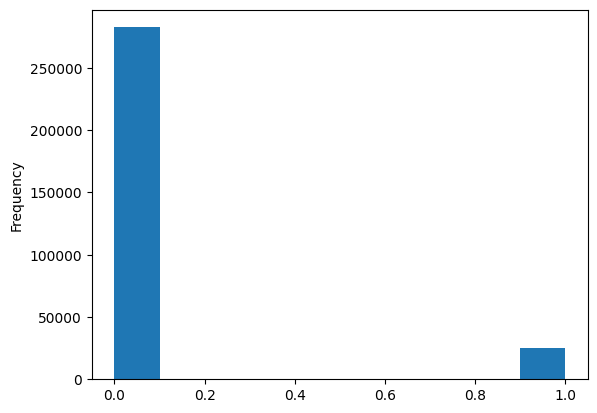

In [ ]:
app_train['TARGET'].astype(int).plot.hist();

Ces informations montrent qu'il s'agit d'un problème de classe déséquilibrée (http://www.chioka.in/class-imbalance-problem/). Il y a beaucoup plus de prêts remboursés à temps que de prêts non remboursés. Lorsque nous utiliserons des modèles d'apprentissage automatique plus sophistiqués, nous pourrons pondérer les classes (http://xgboost.readthedocs.io/en/latest/parameter.html) en fonction de leur représentation dans les données afin de refléter ce déséquilibre.

## Étude des valeurs manquantes
Nous pouvons ensuite examiner le nombre et le pourcentage de valeurs manquantes dans chaque colonne.

In [ ]:
# Fonction pour calculer les valeurs manquantes par colonne
def missing_values_table(df):
        # Total des valeurs manquantes
        mis_val = df.isnull().sum()

        # Pourcentage de valeurs manquantes
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Créer un tableau avec les résultats
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Renommer les colonnes
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Trier le tableau par pourcentage de manquants en ordre décroissant
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Afficher quelques informations sommaires
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Retourner le cadre de données avec les informations manquantes
        return mis_val_table_ren_columns

In [ ]:
# Statistiques des valeurs manquantes
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MEDI                   214865             69.900
COMMONAREA_AVG                    214865             69.900
COMMONAREA_MODE                   214865             69.900
NONLIVINGAPARTMENTS_MEDI          213514             69.400
NONLIVINGAPARTMENTS_MODE          213514             69.400
NONLIVINGAPARTMENTS_AVG           213514             69.400
FONDKAPREMONT_MODE                210295             68.400
LIVINGAPARTMENTS_MODE             210199             68.400
LIVINGAPARTMENTS_MEDI             210199             68.400
LIVINGAPARTMENTS_AVG              210199             68.400
FLOORSMIN_MODE                    208642             67.800
FLOORSMIN_MEDI                    208642             67.800
FLOORSMIN_AVG                     208642             67.800
YEARS_BUILD_MODE                  204488             66.500
YEARS_BUILD_MEDI                  204488             66.500
YEARS_BUILD_AVG                   204488             66.500
OWN_CAR_AGE                       202929             66.000
LANDAREA_AVG                      182590             59.400
LANDAREA_MEDI                     182590             59.400
LANDAREA_MODE                     182590             59.400

Lorsqu'il s'agira de construire nos modèles d'apprentissage automatique, nous devrons compléter ces valeurs manquantes (ce que l'on appelle l'imputation). Dans un travail ultérieur, nous utiliserons des modèles tels que XGBoost qui peuvent traiter les valeurs manquantes sans nécessiter d'imputation (https://stats.stackexchange.com/questions/235489/xgboost-can-handle-missing-data-in-the-forecasting-phase). Une autre option consisterait à supprimer les colonnes présentant un pourcentage élevé de valeurs manquantes, bien qu'il soit impossible de savoir à l'avance si ces colonnes seront utiles à notre modèle. Par conséquent, nous conserverons toutes les colonnes pour l'instant.

## Types de colonnes
Examinons le nombre de colonnes de chaque type de données. int64 et float64 sont des variables numériques (qui peuvent être discrètes ou continues). les colonnes d'objets contiennent des chaînes de caractères et sont des caractéristiques catégorielles.

In [ ]:
# Nombre de chaque type de colonne
print('* Nombre de colonne dans chaque type de données dans le fichier app_train')
display(app_train.dtypes.value_counts())
print( )
print('* Nombre de colonne dans chaque type de données dans le fichier app_test')
app_test.dtypes.value_counts()

* Nombre de colonne dans chaque type de données dans le fichier app_train


float64    65
int64      41
object     16
dtype: int64


* Nombre de colonne dans chaque type de données dans le fichier app_test


float64    65
int64      40
object     16
dtype: int64

Examinons maintenant le nombre d'entrées uniques dans chacune des colonnes d'objets (catégorielles).

In [ ]:
# Nombre de classes uniques dans chaque colonne d'objets
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

La plupart des variables catégorielles ont un nombre relativement faible d'entrées uniques. Nous devrons trouver un moyen de traiter ces variables catégorielles !

## Encodage des variables catégorielles
Avant d'aller plus loin, nous devons nous occuper des variables catégorielles. Un modèle d'apprentissage automatique ne peut malheureusement pas traiter les variables catégorielles (à l'exception de certains modèles tels que LightGBM). Nous devons donc trouver un moyen d'encoder (représenter) ces variables sous forme de nombres avant de les transmettre au modèle. Il existe deux méthodes principales pour réaliser ce processus :

* Label Encoding : attribuer un nombre entier à chaque catégorie unique d'une variable catégorielle. Aucune nouvelle colonne n'est créée. Un exemple est donné ci-dessous

![image](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/label_encoding.png)

* One-hot encoding: créer une nouvelle colonne pour chaque catégorie unique dans une variable catégorielle. Chaque observation reçoit un 1 dans la colonne de la catégorie correspondante et un 0 dans toutes les autres nouvelles colonnes.

![image](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/one_hot_encoding.png)

Le problème du label encoding st qu'il donne aux catégories un ordre arbitraire. La valeur attribuée à chacune des catégories est aléatoire et ne reflète aucun aspect inhérent à la catégorie. Dans l'exemple ci-dessus, le programmeur reçoit un 4 et le scientifique des données un 1, mais si nous refaisions le même processus, les étiquettes pourraient être inversées ou complètement différentes. L'affectation réelle des nombres entiers est arbitraire. Par conséquent, lorsque nous procédons au label encoding, le modèle peut utiliser la valeur relative de la caractéristique (par exemple, programmeur = 4 et scientifique = 1) pour attribuer des poids, ce qui n'est pas ce que nous voulons. Si nous n'avons que deux valeurs uniques pour une variable catégorielle (telle que Homme/Femme), le codage des étiquettes convient, mais pour plus de deux catégories uniques, le codage à une touche (One-hot) est l'option la plus sûre.

Les mérites relatifs de ces approches font l'objet d'un débat, et certains modèles peuvent traiter sans problème des variables catégorielles codées par des étiquettes. Voici une bonne discussion sur Stack Overflow (https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor). Je pense (et ce n'est qu'une opinion personnelle) que pour les variables catégorielles comportant de nombreuses classes, l'encodage à une touche (One-hot) est l'approche la plus sûre, car elle n'impose pas de valeurs arbitraires aux catégories. Le seul inconvénient de l'encodage à une touche (One-hot) est que le nombre de caractéristiques (dimensions des données) peut exploser avec des variables catégorielles comportant de nombreuses catégories. Pour y remédier, nous pouvons effectuer un codage à une touche suivi d'une [ACP] (http://www.cs.otago.ac.nz/cosc453/student_tutorials/principal_components.pdf) ou d'autres méthodes de réduction de la dimensionnalité (https://www.analyticsvidhya.com/blog/2015/07/dimension-reduction-methods/) afin de réduire le nombre de dimensions (tout en essayant de préserver l'information).

Dans ce notebook, nous utiliserons le Label Encoding pour toutes les variables catégorielles comportant seulement deux catégories et One-hot encoding pour toutes les variables catégorielles comportant plus de deux catégories. Il se peut que ce processus doive être modifié au fur et à mesure que nous avançons dans le projet, mais pour l'instant, nous allons voir où cela nous mène. (Nous n'utiliserons pas non plus de réduction de la dimensionnalité dans ce notebook, mais nous l'explorerons dans des itérations futures).

### Label Encoding et One-Hot Encoding

Mettons en place la politique décrite ci-dessus : pour toute variable catégorielle (`dtype == object`) avec 2 catégories uniques, nous utiliserons label encoding, et pour toute variable catégorielle avec plus de 2 catégories uniques, nous utiliserons one-hot encoding.

Pour label encoding, nous utilisons le Scikit-Learn `LabelEncoder`

et pour one-hot encoding, la fonction pandas `get_dummies(df)`.

In [ ]:
# Créer un objet label encoder
le = LabelEncoder()
le_count = 0

# Itérer à travers les colonnes
for col in app_train:
    if app_train[col].dtype == 'object':
        # Si 2 catégories uniques ou moins
        if len(list(app_train[col].unique())) <= 2:
            # Entraînement sur les données d'entraînement
            le.fit(app_train[col])
            # Transformer les données app_train en données d'entraînement et de test
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])

            # Garder une trace du nombre de colonnes encodées par l'étiquette
            le_count += 1

print('%d colonnes ont été label encoded.' % le_count)

3 colonnes ont été label encoded.


In [ ]:
# one-hot encoding sur les variables catégorielles
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


### Mise en cohérence des données d'entrainement et des données de test

Il doit y avoir les mêmes caractéristiques (colonnes) dans les données d'entrainement et de test. L'encodage One-hot a créé plus de colonnes dans les données d'entrainement parce qu'il y avait des variables catégorielles dont les catégories n'étaient pas représentées dans les données de test.

Pour supprimer les colonnes des données d'entrainement qui ne se trouvent pas dans les données de test, nous devons nous devons harmoniser les ensembles de données. Tout d'abord, nous extrayons la colonne cible des données d'apprentissage (parce qu'elle ne se trouve pas dans les données de test, mais nous devons conserver cette information). Lorsque nous procédons à l'harmonisation, nous devons nous assurer que l'axe = 1 pour aligner les images de données sur les colonnes et non sur les lignes !

In [ ]:
train_labels = app_train['TARGET']

# Harmonisation des données d'entrainement et de test, en ne conservant que les colonnes présentes dans les deux ensembles de données.
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Ajouter la target à l'intérieur
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


Les ensembles de données d'entrainement et de test ont désormais les mêmes caractéristiques, ce qui est nécessaire pour l'apprentissage automatique. Le nombre de caractéristiques a augmenté de manière significative en raison de l'encodage one-hot. À un moment donné, nous voudrons probablement essayer de réduire la dimensionnalité (en supprimant les caractéristiques qui ne sont pas pertinentes) afin de réduire la taille des ensembles de données.

## Retour à l'analyse exploratoire des données

### Anomalies

Les anomalies dans les données constituent un problème auquel il faut toujours être attentif lors de l'analyse exploratoire des données. Celles-ci peuvent être dues à des chiffres mal saisis, à des erreurs dans l'équipement de mesure ou à des mesures valables mais extrêmes. L'une des façons de détecter les anomalies de manière quantitative est d'examiner les statistiques d'une colonne à l'aide de la méthode de description. Les chiffres de la colonne DAYS_BIRTH sont négatifs parce qu'ils sont enregistrés par rapport à la demande de prêt en cours. Pour voir ces statistiques en années, nous pouvons multiplier par -1 et diviser par le nombre de jours dans une année :



In [ ]:
(app_train['DAYS_BIRTH'] / -365).describe()

count   307511.000
mean        43.937
std         11.956
min         20.518
25%         34.008
50%         43.151
75%         53.923
max         69.121
Name: DAYS_BIRTH, dtype: float64

Ces âges semblent raisonnables. Il n'y a pas de valeurs aberrantes pour l'âge, que ce soit à l'extrémité supérieure ou inférieure. Qu'en est-il des jours d'emploi ?

In [ ]:
app_train['DAYS_EMPLOYED'].describe()

count   307511.000
mean     63815.046
std     141275.767
min     -17912.000
25%      -2760.000
50%      -1213.000
75%       -289.000
max     365243.000
Name: DAYS_EMPLOYED, dtype: float64

Cela ne semble pas correct ! La valeur maximale (en plus d'être positive) est d'environ 1000 ans !

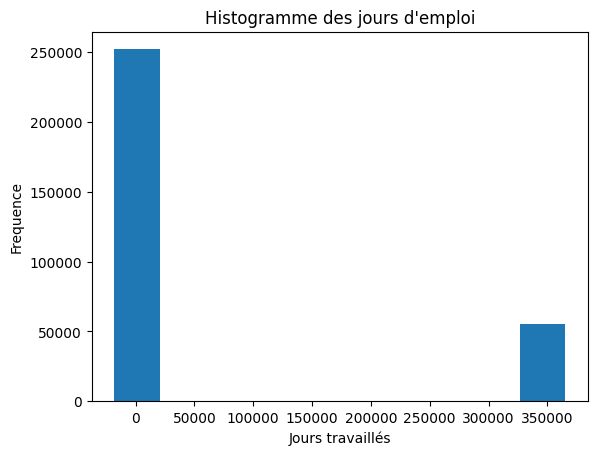

In [ ]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Histogramme des jours d\'emploi');
plt.xlabel('Jours travaillés');
plt.ylabel('Frequence');

Par simple curiosité, nous allons regrouper les clients présentant des anomalies et voir s'ils ont tendance à avoir des taux de défaillance plus élevés ou plus faibles que le reste des clients.

In [ ]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('Les personnes ne présentant pas d\'anomalie sont défaillantes dans %0.2f%% des prêts' % (100 * non_anom['TARGET'].mean()))
print('Les personnes présentant des anomalies sont en défaut de paiement sur %0.2f%% des prêts' % (100 * anom['TARGET'].mean()))
print('Il y a %d jours anormaux d\'emploi' % len(anom))

Les personnes ne présentant pas d'anomalie sont défaillantes dans 8.66% des prêts
Les personnes présentant des anomalies sont en défaut de paiement sur 5.40% des prêts
Il y a 55374 jours anormaux d'emploi


Voilà qui est extrêmement intéressant ! Il s'avère que les anomalies ont un taux de défaillance plus faible.

Le traitement des anomalies dépend de la situation exacte et il n'existe pas de règles fixes. L'une des approches les plus sûres consiste à définir les anomalies comme des valeurs manquantes et à les compléter (à l'aide de l'imputation) avant l'apprentissage automatique. Dans ce cas, comme toutes les anomalies ont exactement la même valeur, nous voulons les compléter avec la même valeur au cas où tous ces prêts auraient quelque chose en commun. Les valeurs anormales semblent avoir une certaine importance, c'est pourquoi nous voulons indiquer au modèle d'apprentissage automatique si nous avons effectivement renseigné ces valeurs. Comme solution, nous remplirons les valeurs anormales avec not a number (np.nan) et créerons ensuite une nouvelle colonne booléenne indiquant si la valeur était anormale ou non.



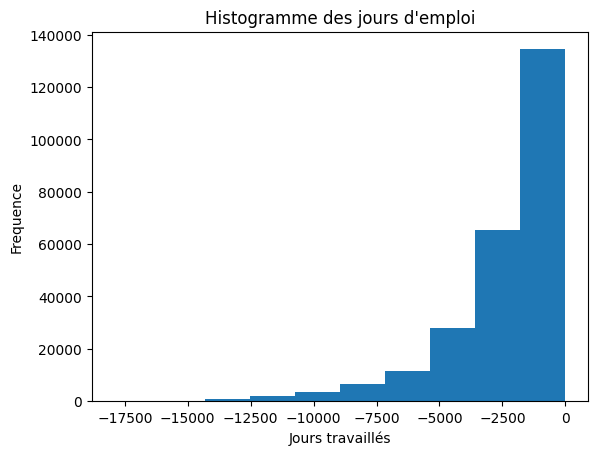

In [ ]:
# Création d'une colonne de marqueur d'anomalie
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Remplacer les valeurs anormales par nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Histogramme des jours d\'emploi');
plt.xlabel('Jours travaillés');
plt.ylabel('Frequence');

La distribution semble beaucoup plus conforme à ce que nous attendons, et nous avons également créé une nouvelle colonne pour indiquer au modèle que ces valeurs étaient à l'origine anormales (parce que nous devrons remplir les nans avec une certaine valeur, probablement la médiane de la colonne). Les autres colonnes contenant des jours dans le cadre de données semblent correspondre à ce que nous attendons et ne présentent pas de valeurs aberrantes évidentes.

Il est extrêmement important de noter que tout ce que nous faisons sur les données d'entraînement, nous devons également le faire sur les données de test. Veillons à créer la nouvelle colonne et à remplir la colonne existante avec np.nan dans les données de test.

In [ ]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('Il y a %d anomalies dans les données de test sur %d entrées.' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

Il y a 9274 anomalies dans les données de test sur 48744 entrées.


### Correlations

Maintenant que nous avons traité les variables catégorielles et les valeurs aberrantes, poursuivons avec l'ADE. Une façon d'essayer de comprendre les données est de rechercher des corrélations entre les caractéristiques et la cible. Nous pouvons calculer le coefficient de corrélation de Pearson entre chaque variable et la cible à l'aide de la méthode .corr dataframe.

Le coefficient de corrélation n'est pas la meilleure méthode pour représenter la "pertinence" d'une caractéristique, mais il nous donne une idée des relations possibles entre les données. Voici quelques interprétations générales de la valeur absolue du coefficient de corrélation :

.00-.19 "très faible"
.20-.39 "faible"
.40-.59 "modéré"
.60-.79 "fort"
.80-1.0 "très fort"


In [ ]:
# Trouver des corrélations avec la cible et trier
correlations = app_train.corr()['TARGET'].sort_values()

# Afficher les corrélations
display('Corrélations les plus positives:', correlations.tail(15))
print( )
print('--'*50)
display('Corrélations les plus negatives:', correlations.head(15))

'Corrélations les plus positives:'

OCCUPATION_TYPE_Laborers                            0.043
FLAG_DOCUMENT_3                                     0.044
REG_CITY_NOT_LIVE_CITY                              0.044
FLAG_EMP_PHONE                                      0.046
NAME_EDUCATION_TYPE_Secondary / secondary special   0.050
REG_CITY_NOT_WORK_CITY                              0.051
DAYS_ID_PUBLISH                                     0.051
CODE_GENDER_M                                       0.055
DAYS_LAST_PHONE_CHANGE                              0.055
NAME_INCOME_TYPE_Working                            0.057
REGION_RATING_CLIENT                                0.059
REGION_RATING_CLIENT_W_CITY                         0.061
DAYS_EMPLOYED                                       0.075
DAYS_BIRTH                                          0.078
TARGET                                              1.000
Name: TARGET, dtype: float64


----------------------------------------------------------------------------------------------------


'Corrélations les plus negatives:'

EXT_SOURCE_3                           -0.179
EXT_SOURCE_2                           -0.160
EXT_SOURCE_1                           -0.155
NAME_EDUCATION_TYPE_Higher education   -0.057
CODE_GENDER_F                          -0.055
NAME_INCOME_TYPE_Pensioner             -0.046
DAYS_EMPLOYED_ANOM                     -0.046
ORGANIZATION_TYPE_XNA                  -0.046
FLOORSMAX_AVG                          -0.044
FLOORSMAX_MEDI                         -0.044
FLOORSMAX_MODE                         -0.043
EMERGENCYSTATE_MODE_No                 -0.042
HOUSETYPE_MODE_block of flats          -0.041
AMT_GOODS_PRICE                        -0.040
REGION_POPULATION_RELATIVE             -0.037
Name: TARGET, dtype: float64

Examinons quelques-unes des corrélations les plus significatives : la corrélation DAYS_BIRTH est la plus positive (sauf pour TARGET, car la corrélation d'une variable avec elle-même est toujours de 1 ! (sauf pour TARGET, car la corrélation d'une variable avec elle-même est toujours de 1 !) Si l'on examine la documentation, DAYS_BIRTH est l'âge en jours du client au moment du prêt en jours négatifs (quelle qu'en soit la raison !). La corrélation est positive, mais la valeur de cette caractéristique est en fait négative, ce qui signifie que plus le client vieillit, moins il est susceptible de ne pas rembourser son prêt (c'est-à-dire que la cible == 0). C'est un peu déroutant, nous prendrons donc la valeur absolue de la caractéristique et la corrélation sera négative.

### Effet de l'âge sur le remboursement

In [ ]:
# Trouver la corrélation entre les jours positifs depuis birth et target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982694

Plus le client est âgé, plus il existe une relation linéaire négative avec la target, ce qui signifie que plus les clients sont âgés, plus ils ont tendance à rembourser leurs prêts à temps.

Commençons par examiner cette variable. Tout d'abord, nous pouvons faire un histogramme de l'âge. L'axe des x sera exprimé en années pour rendre le graphique un peu plus compréhensible.

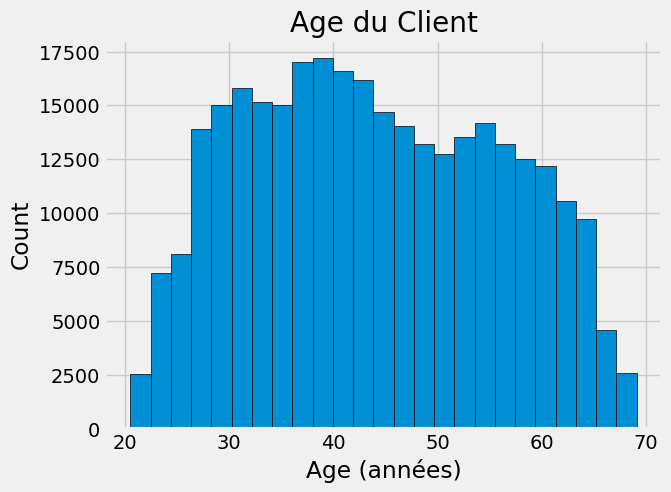

In [ ]:
# Définir le style de tracé
plt.style.use('fivethirtyeight')

# Tracer la distribution des âges en années
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age du Client'); plt.xlabel('Age (années)'); plt.ylabel('Count');

En soi, la distribution de l'âge ne nous apprend pas grand-chose, si ce n'est qu'il n'y a pas de valeurs aberrantes puisque tous les âges sont raisonnables. Pour visualiser l'effet de l'âge sur la cible, nous allons ensuite tracer un graphique d'estimation de la densité du noyau (KDE) coloré par la valeur de la target.

Un graphique d'estimation de la densité du noyau montre la distribution d'une variable unique et peut être considéré comme un histogramme lissé (il est créé en calculant un noyau, généralement une gaussienne, à chaque point de données, puis en faisant la moyenne de tous les noyaux individuels pour développer une seule courbe lisse). Nous utiliserons le kdeplot de seaborn pour ce graphique.

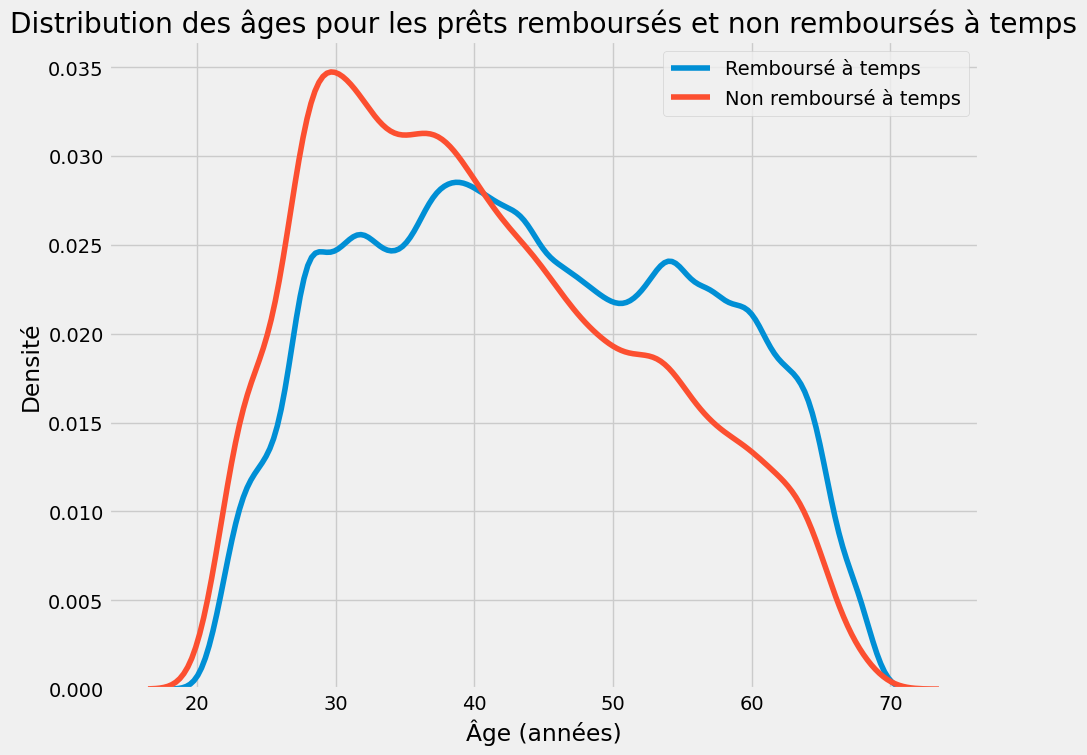

In [ ]:
plt.figure(figsize=(10, 8))

# Graphique KDE des prêts remboursés à temps
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label='Remboursé à temps')

# Graphique KDE des prêts qui n'ont pas été remboursés à temps
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label='Non remboursé à temps')

# Annotation de graphe
plt.xlabel('Âge (années)')
plt.ylabel('Densité')
plt.title('Distribution des âges pour les prêts remboursés et non remboursés à temps')
plt.legend()
plt.show()


La courbe de la cible == 1 penche vers l'extrémité la plus jeune de la distribution. Bien qu'il ne s'agisse pas d'une corrélation significative (coefficient de corrélation de -0,07), cette variable sera probablement utile dans un modèle d'apprentissage automatique car elle affecte la cible. Examinons cette relation sous un autre angle : le taux moyen de non-remboursement des prêts par tranche d'âge.

Pour réaliser ce graphique, nous découpons d'abord la catégorie d'âge en tranches de 5 ans chacune. Ensuite, pour chaque tranche, nous calculons la valeur moyenne de la cible, qui nous indique le ratio de prêts non remboursés dans chaque catégorie d'âge.

In [ ]:
# Les informations relatives à l'âge sont stockées dans un dataframe séparé
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin sur les données sur l'âge
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1        9461       25.921  (25.0, 30.0]
1       0       16765       45.932  (45.0, 50.0]
2       0       19046       52.181  (50.0, 55.0]
3       0       19005       52.068  (50.0, 55.0]
4       0       19932       54.608  (50.0, 55.0]
5       0       16941       46.414  (45.0, 50.0]
6       0       13778       37.748  (35.0, 40.0]
7       0       18850       51.644  (50.0, 55.0]
8       0       20099       55.066  (55.0, 60.0]
9       0       14469       39.641  (35.0, 40.0]

In [ ]:
# Regroupement par le bin et calcul des moyennes
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET  DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                 
(20.0, 25.0]   0.123    8532.796       23.378
(25.0, 30.0]   0.111   10155.219       27.823
(30.0, 35.0]   0.103   11854.848       32.479
(35.0, 40.0]   0.089   13707.908       37.556
(40.0, 45.0]   0.078   15497.661       42.459
(45.0, 50.0]   0.074   17323.900       47.463
(50.0, 55.0]   0.067   19196.495       52.593
(55.0, 60.0]   0.055   20984.263       57.491
(60.0, 65.0]   0.053   22780.547       62.412
(65.0, 70.0]   0.037   24292.614       66.555

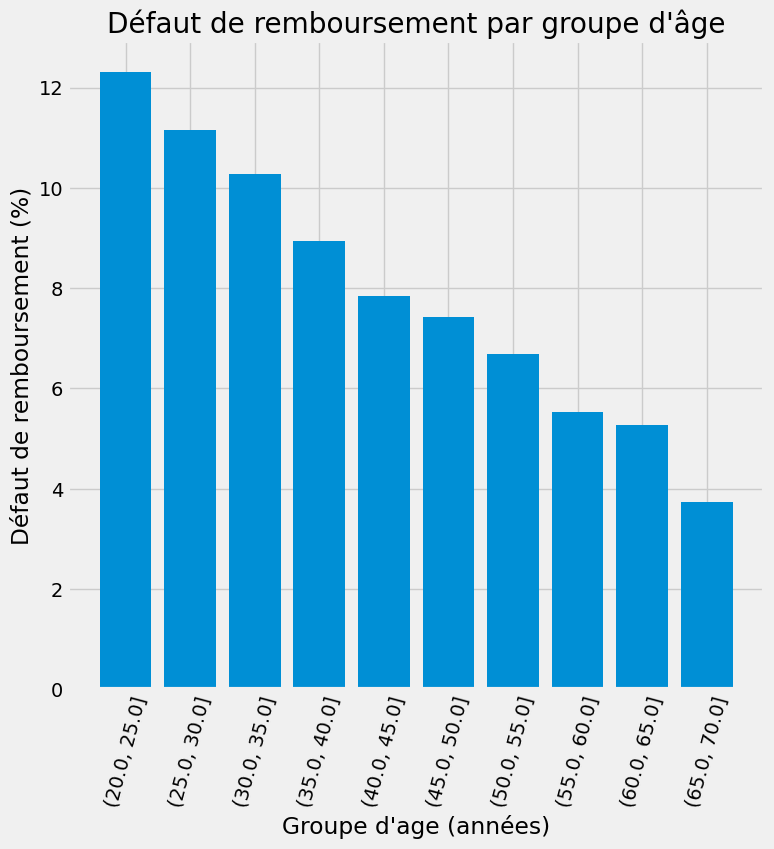

In [ ]:
plt.figure(figsize = (8, 8))

# Représentation graphique des tranches d'âge et de la moyenne de la target sous la forme d'un diagramme à barres.
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Annotation de graphe
plt.xticks(rotation = 75); plt.xlabel('Groupe d\'age (années)'); plt.ylabel('Défaut de remboursement (%)')
plt.title('Défaut de remboursement par groupe d\'âge');

La tendance est claire : les jeunes demandeurs sont plus susceptibles de ne pas rembourser le prêt ! Le taux de non-remboursement est supérieur à 10 % pour les trois groupes d'âge les plus jeunes et inférieur à 5 % pour le groupe le plus âgé.

Il s'agit d'une information qui pourrait être directement utilisée par la banque : étant donné que les jeunes clients sont moins susceptibles de rembourser le prêt, il conviendrait peut-être de leur fournir davantage de conseils ou d'astuces en matière de planification financière. Cela ne signifie pas que la banque doive discriminer les jeunes clients, mais il serait judicieux de prendre des mesures de précaution pour les aider à rembourser à temps.

### Sources Extérieures

Les 3 variables ayant les plus fortes corrélations négatives avec la cible sont EXT_SOURCE_1, EXT_SOURCE_2, et EXT_SOURCE_3.

Selon la documentation, ces caractéristiques représentent un "score normalisé de la source de données externe". Je ne sais pas exactement ce que cela signifie, mais il pourrait s'agir d'une sorte d'évaluation de crédit cumulative réalisée à partir de nombreuses sources de données.

Examinons ces variables.

Tout d'abord, nous pouvons montrer les corrélations des caractéristiques EXT_SOURCE avec la traget et entre elles.


In [ ]:
# Extraire les variables EXT_SOURCE et montrer les corrélations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET         1.000        -0.155        -0.160        -0.179      -0.078
EXT_SOURCE_1  -0.155         1.000         0.214         0.187       0.601
EXT_SOURCE_2  -0.160         0.214         1.000         0.109       0.092
EXT_SOURCE_3  -0.179         0.187         0.109         1.000       0.205
DAYS_BIRTH    -0.078         0.601         0.092         0.205       1.000

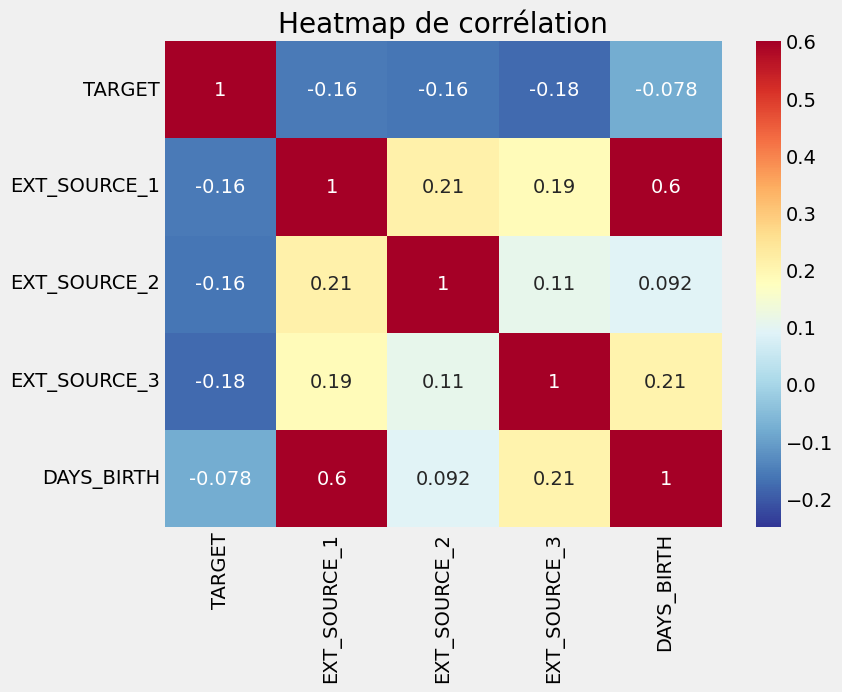

In [ ]:
plt.figure(figsize = (8, 6))

# Heatmap de corrélations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Heatmap de corrélation');

Les trois caractéristiques EXT_SOURCE ont des corrélations négatives avec la cible, ce qui indique que plus la valeur de l'EXT_SOURCE augmente, plus le client est susceptible de rembourser le prêt. Nous pouvons également constater que DAYS_BIRTH est positivement corrélé avec EXT_SOURCE_1, ce qui indique que l'âge du client est peut-être l'un des facteurs de ce score.

Nous pouvons ensuite examiner la distribution de chacune de ces caractéristiques en fonction de la valeur de la target. Cela nous permettra de visualiser l'effet de cette variable sur la target.

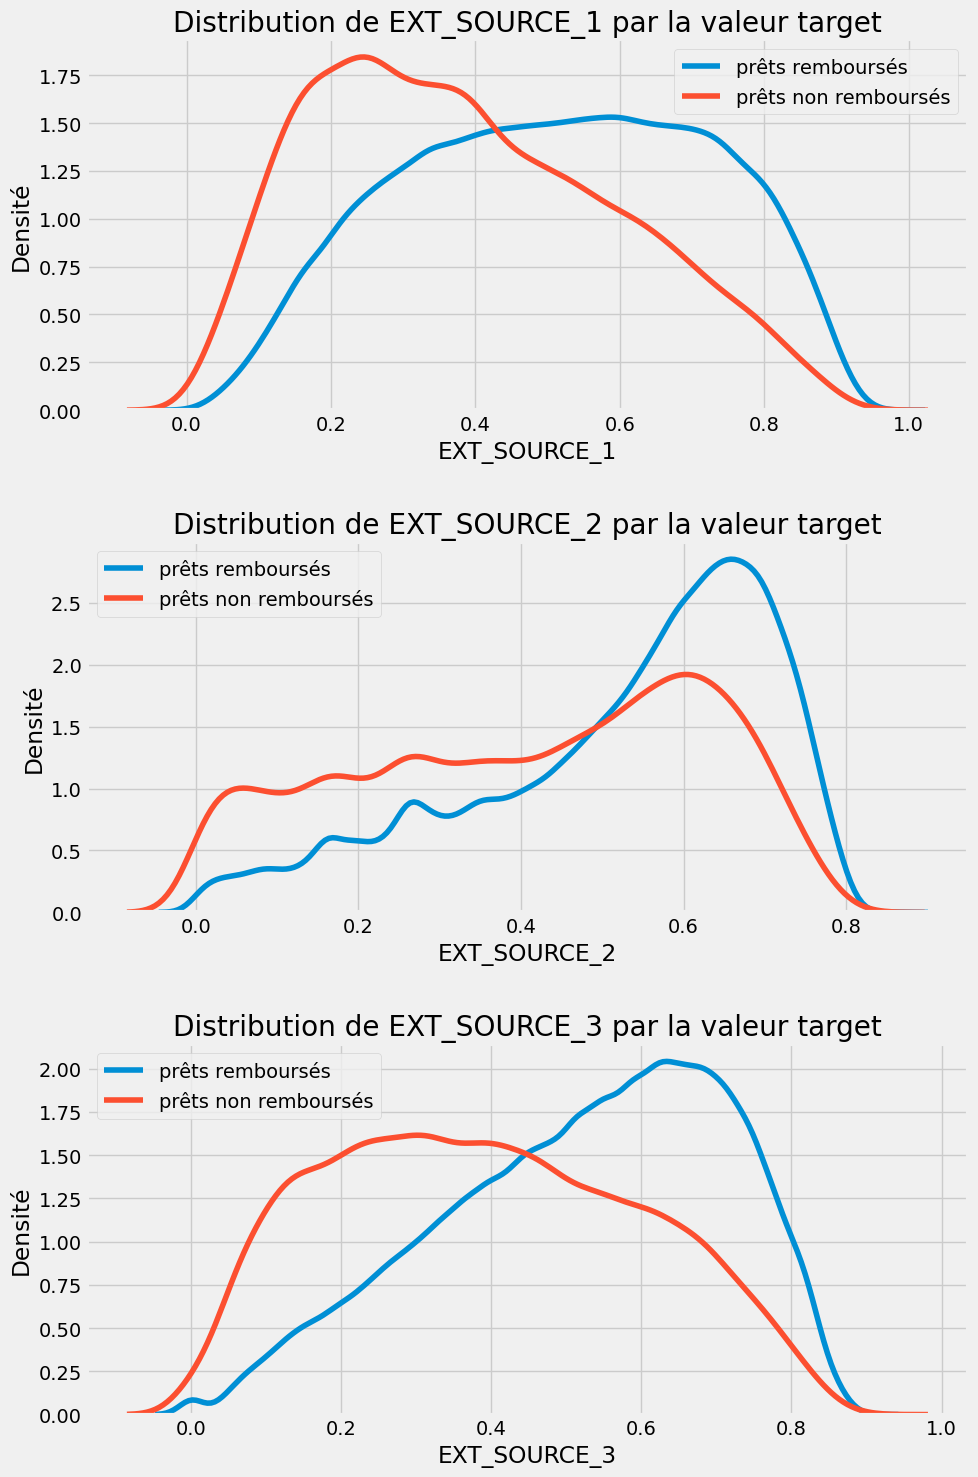

In [ ]:
plt.figure(figsize=(10, 15))

# itérer à travers les sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    # créer un nouveau sous-graphe pour chaque source
    plt.subplot(3, 1, i + 1)

    # plot des prêts remboursés
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label='prêts remboursés')
    # plot les prêts non remboursés
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label='prêts non remboursés')

    # Annotation de graphe
    plt.title('Distribution de %s par la valeur target' % source)
    plt.xlabel('%s' % source)
    plt.ylabel('Densité')

    # Ajout de la légende
    plt.legend()

plt.tight_layout(h_pad=2.5)


`EXT_SOURCE_3` affiche la plus grande différence entre les valeurs de la cible. Nous pouvons clairement voir que cette caractéristique a une certaine relation avec la probabilité qu'un demandeur rembourse un prêt. La relation n'est pas très forte (en fait, elles sont toutes considérées comme très faibles (http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf), mais ces variables seront toujours utiles pour un modèle d'apprentissage automatique permettant de prédire si un demandeur remboursera ou non un prêt dans les délais.

## Pairs Plot

En guise de dernier graphique exploratoire, nous pouvons réaliser un graphique par paires des variables `EXT_SOURCE` et de la variable `DAYS_BIRTH`.

Le Graphe des paires (https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166) est un excellent outil d'exploration car il nous permet de voir les relations entre plusieurs paires de variables ainsi que les distributions de variables uniques. Ici, nous utilisons la bibliothèque de visualisation seaborn et la fonction PairGrid pour créer un diagramme de paires avec des diagrammes de dispersion dans le triangle supérieur, des histogrammes sur la diagonale et des diagrammes de densité de noyau en 2D et des coefficients de corrélation dans le triangle inférieur.

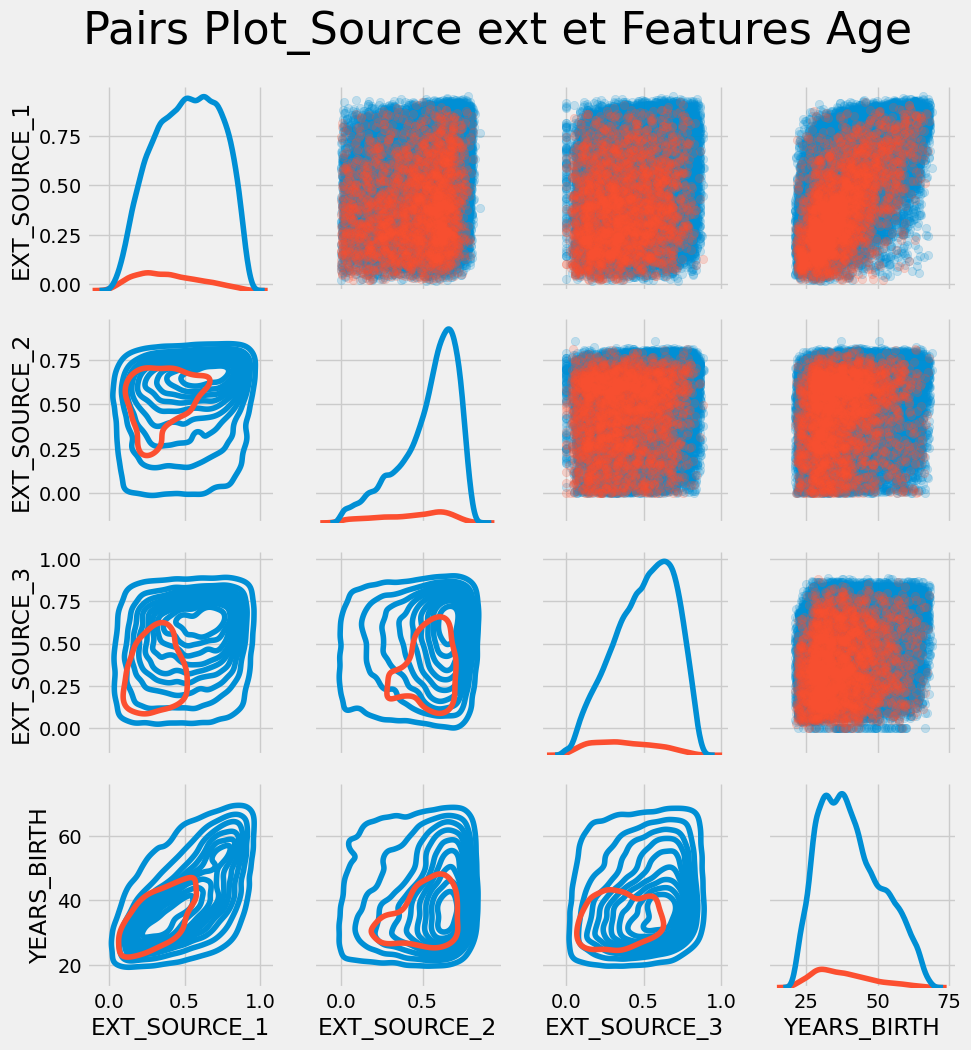

In [ ]:
# Copier les données pour le graphe
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Ajouter l'âge du client en années
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Supprimer les valeurs nan et limiter aux 100.000 premières lignes
plot_data = plot_data.dropna().loc[:100000, :]

# Fonction permettant de calculer le coefficient de corrélation entre deux colonnes
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Créer l'objet pairgrid
grid = sns.PairGrid(data = plot_data, diag_sharey=False,
                    hue = 'TARGET',
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# # La partie supérieure est un diagramme de dispersion (scatter plot)
grid.map_upper(plt.scatter, alpha = 0.2)

# La diagonale est un histogramme
grid.map_diag(sns.kdeplot)

# # Le bas est un diagramme de densité (density plot)
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle(' Pairs Plot_Source ext et Features Age', size = 32, y = 1.05);

Dans ce graphique, le rouge indique les prêts qui n'ont pas été remboursés et le bleu les prêts qui ont été remboursés. Nous pouvons voir les différentes relations au sein des données. Il semble y avoir une relation linéaire positive modérée entre EXT_SOURCE_1 et DAYS_BIRTH (ou YEARS_BIRTH), ce qui indique que cette caractéristique peut prendre en compte l'âge du client.

# Feature Engineering

S'il est important de choisir le bon modèle et les paramètres optimaux, le modèle ne peut apprendre qu'à partir des données qui lui sont fournies. S'assurer que ces données sont aussi pertinentes que possible pour la tâche est le travail du data scientist (et peut-être de quelques outils automatisés (https://docs.featuretools.com/getting_started/install.html) pour nous aider).

Le Feature Engineering se réfère à un processus général et peut impliquer à la fois la construction de features : ajouter de nouvelles features à partir des données existantes, et la sélection de features : choisir uniquement les features les plus importantes ou d'autres méthodes de réduction de la dimensionnalité. Il existe de nombreuses techniques permettant de créer et de sélectionner des caractéristiques.

Dans ce notebook, nous ferons beaucoup de technique de Feature Engineering.


## Polynomial Features

Une des méthodes simples de construction de features est celle appelée polynomial features (http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html). Dans cette méthode, nous créons des features qui sont des composantes des features existantes ainsi que des termes d'interaction entre les features existantes. Par exemple, nous pouvons créer les variables `EXT_SOURCE_1^2` et `EXT_SOURCE_2^2` ainsi que des variables telles que `EXT_SOURCE_1` x `EXT_SOURCE_2`, `EXT_SOURCE_1` x `EXT_SOURCE_2^2`, `EXT_SOURCE_1^2` x `EXT_SOURCE_2^2`, et ainsi de suite. Ces features qui sont une combinaison de plusieurs variables individuelles sont appelées termes d'interaction (https://en.wikipedia.org/wiki/Interaction_(statistics) parce qu'elles capturent les interactions entre les variables. En d'autres termes, si deux variables en elles-mêmes n'ont pas une grande influence sur la cible, le fait de les combiner en une seule variable d'interaction peut révéler une relation avec la cible. Les termes d'interaction sont couramment utilisés dans les modèles statistiques (https://www.theanalysisfactor.com/interpreting-interactions-in-regression/) pour capturer les effets de plusieurs variables, mais je ne les vois pas aussi souvent utilisés dans l'apprentissage automatique. Néanmoins, nous pouvons en essayer quelques-uns pour voir s'ils peuvent aider notre modèle à prédire si un client remboursera ou non un prêt.

Dans le code suivant, nous créons des features polynomiales en utilisant les variables `EXT_SOURCE` et la variable `DAYS_BIRTH`. Scikit-Learn dispose d'une classe utile appelée `PolynomialFeatures` (http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) qui crée les polynômes et les termes d'interaction jusqu'à un degré spécifié. Nous pouvons utiliser un degré de 3 pour voir les résultats (lorsque nous créons des caractéristiques polynomiales, nous voulons éviter d'utiliser un degré trop élevé, à la fois parce que le nombre de features augmente de façon exponentielle avec le degré, et parce que nous pouvons rencontrer des problèmes de surajustement (http://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html#sphx-glr-auto-examples-model-selection-plot-underfitting-overfitting-py)).

In [ ]:
# Créer un nouveau dataframe pour les features polynomiales
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

In [ ]:
# Importer SimpleImputer au lieu de Imputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

In [ ]:
# Créons nos variables :
poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns=['TARGET'])

In [ ]:
# Nécessité d'imputer les valeurs manquantes
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures

# Créer l'objet polynomial avec le degré spécifié
poly_transformer = PolynomialFeatures(degree=3)

In [ ]:
# Entraînement des features polynomiales
poly_transformer.fit(poly_features)

PolynomialFeatures(degree=3)

In [ ]:
# Transformation des features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)

print('Polynomial Features shape: ', poly_features.shape)
print('Polynomial Features test shape: ', poly_features_test.shape)

Polynomial Features shape:  (307511, 35)
Polynomial Features test shape:  (48744, 35)


Cela crée un nombre considérable de nouvelles features. Pour obtenir les noms, nous devons utiliser la méthode get_feature_names des caractéristiques polynomiales.

In [ ]:
# Obtenez les noms des colonnes d'entrée
input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']

# Obtenez les noms des fonctionnalités polynomiales en utilisant les noms des colonnes d'entrée
poly_transformer.get_feature_names_out(input_features)[:15]

array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2'], dtype=object)

Il y a 35 features avec des features individuelles augmentées à des puissances allant jusqu'au degré 3 et des termes d'interaction. Nous pouvons maintenant voir si l'une de ces nouvelles caractéristiques est corrélée avec la cible.

In [ ]:
# Créer un dataframe à partir des features
poly_features = pd.DataFrame(poly_features,
                             columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2',
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))
poly_features.head()

1  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH  EXT_SOURCE_1^2  \
0 1.000         0.083         0.263         0.139    9461.000           0.007   
1 1.000         0.311         0.622         0.535   16765.000           0.097   
2 1.000         0.506         0.556         0.730   19046.000           0.256   
3 1.000         0.506         0.650         0.535   19005.000           0.256   
4 1.000         0.506         0.323         0.535   19932.000           0.256   

   EXT_SOURCE_1 EXT_SOURCE_2  EXT_SOURCE_1 EXT_SOURCE_3  \
0                      0.022                      0.012   
1                      0.194                      0.167   
2                      0.281                      0.369   
3                      0.329                      0.271   
4                      0.163                      0.271   

   EXT_SOURCE_1 DAYS_BIRTH  EXT_SOURCE_2^2  EXT_SOURCE_2 EXT_SOURCE_3  \
0                  785.613           0.069                      0.037   
1                 5218.396           0.387                      0.333   
2                 9637.237           0.309                      0.406   
3                 9616.491           0.423                      0.348   
4                10085.551           0.104                      0.173   

   EXT_SOURCE_2 DAYS_BIRTH  EXT_SOURCE_3^2  EXT_SOURCE_3 DAYS_BIRTH  \
0                 2487.757           0.019                 1318.634   
1                10431.950           0.287                 8973.906   
2                10587.902           0.532                13895.327   
3                12361.644           0.287                10172.925   
4                 6432.820           0.287                10669.126   

   DAYS_BIRTH^2  EXT_SOURCE_1^3  EXT_SOURCE_1^2 EXT_SOURCE_2  \
0  89510521.000           0.001                        0.002   
1 281065225.000           0.030                        0.060   
2 362750116.000           0.130                        0.142   
3 361190025.000           0.130                        0.167   
4 397284624.000           0.130                        0.083   

   EXT_SOURCE_1^2 EXT_SOURCE_3  EXT_SOURCE_1^2 DAYS_BIRTH  \
0                        0.001                     65.235   
1                        0.052                   1624.316   
2                        0.187                   4876.422   
3                        0.137                   4865.924   
4                        0.137                   5103.268   

   EXT_SOURCE_1 EXT_SOURCE_2^2  EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3  \
0                        0.006                                   0.003   
1                        0.121                                   0.104   
2                        0.156                                   0.205   
3                        0.214                                   0.176   
4                        0.053                                   0.087   

   EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH  EXT_SOURCE_1 EXT_SOURCE_3^2  \
0                               206.576                        0.002   
1                              3247.125                        0.089   
2                              5357.456                        0.269   
3                              6254.966                        0.145   
4                              3254.993                        0.145   

   EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH  EXT_SOURCE_1 DAYS_BIRTH^2  \
0                               109.495                7432682.213   
1                              2793.284               87486416.909   
2                              7031.007              183550807.987   
3                              5147.479              182761405.169   
4                              5398.556              201025197.566   

   EXT_SOURCE_2^3  EXT_SOURCE_2^2 EXT_SOURCE_3  EXT_SOURCE_2^2 DAYS_BIRTH  \
0           0.018                        0.010                    654.152   
1           0.241                        0.207                   6491.237   
2           0.17

In [ ]:
# Ajouter dans la target
poly_features['TARGET'] = poly_target

In [ ]:
# Trouver les correlations avec la target
poly_corrs = poly_features.corr()['TARGET'].sort_values()
poly_corrs

EXT_SOURCE_2 EXT_SOURCE_3                -0.194
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.190
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172
EXT_SOURCE_1 EXT_SOURCE_2                -0.167
EXT_SOURCE_1 EXT_SOURCE_3                -0.164
EXT_SOURCE_2                             -0.160
EXT_SOURCE_2 DAYS_BIRTH                  -0.157
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.157
EXT_SOURCE_3                             -0.156
EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH     -0.156
EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH     -0.152
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.151
EXT_SOURCE_3 DAYS_BIRTH                  -0.150
EXT_SOURCE_2^2                           -0.150
EXT_SOURCE_2^2 DAYS_BIRTH                -0.149
EXT_SOURCE_3^2 DAYS_BIRTH                -0.142
EXT_SOURCE_3^2                           -0.142
EXT_SOURCE_2^3                           -0.140
EXT_SOURCE_1^2 EXT_SOURCE_2             

In [ ]:
# Affichage des valeurs les plus négatives et les plus positives
print('* Affichage des valeurs les plus négatives')
print(poly_corrs.head(10))

print( )
print('* Affichage des valeurs proches de 1 et des valeurs positives')
print(poly_corrs.tail(10))

* Affichage des valeurs les plus négatives
EXT_SOURCE_2 EXT_SOURCE_3                -0.194
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.190
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172
EXT_SOURCE_1 EXT_SOURCE_2                -0.167
EXT_SOURCE_1 EXT_SOURCE_3                -0.164
EXT_SOURCE_2                             -0.160
EXT_SOURCE_2 DAYS_BIRTH                  -0.157
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.157
Name: TARGET, dtype: float64

* Affichage des valeurs proches de 1 et des valeurs positives
EXT_SOURCE_1                -0.099
EXT_SOURCE_1^2 DAYS_BIRTH   -0.098
EXT_SOURCE_1 DAYS_BIRTH^2   -0.095
EXT_SOURCE_1^2              -0.091
EXT_SOURCE_1^3              -0.083
DAYS_BIRTH                  -0.078
DAYS_BIRTH^2                -0.077
DAYS_BIRTH^3                -0.074
TARGET                       1.000
1                              NaN
Name: TARGET, dtype: float64


Plusieurs des nouvelles variables ont une corrélation plus importante (en termes de magnitude absolue) avec la cible que les features originales. Lorsque nous construisons des modèles d'apprentissage automatique, nous pouvons essayer avec et sans ces features pour déterminer si elles aident réellement le modèle à apprendre.

Nous ajouterons ces features à une copie des données d'apprentissage et de test, puis nous évaluerons les modèles avec et sans ces features. Dans le domaine de l'apprentissage automatique, la seule façon de savoir si une approche fonctionne est de l'essayer !

In [ ]:
# Mettre les features test dans le dataframe
poly_features_test = pd.DataFrame(poly_features_test,
                                  columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2',
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))
poly_features_test.head()

1  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH  EXT_SOURCE_1^2  \
0 1.000         0.753         0.790         0.160  -19241.000           0.566   
1 1.000         0.565         0.292         0.433  -18064.000           0.319   
2 1.000         0.506         0.700         0.611  -20038.000           0.256   
3 1.000         0.526         0.510         0.613  -13976.000           0.276   
4 1.000         0.202         0.426         0.535  -13040.000           0.041   

   EXT_SOURCE_1 EXT_SOURCE_2  EXT_SOURCE_1 EXT_SOURCE_3  \
0                      0.594                      0.120   
1                      0.165                      0.245   
2                      0.354                      0.309   
3                      0.268                      0.322   
4                      0.086                      0.108   

   EXT_SOURCE_1 DAYS_BIRTH  EXT_SOURCE_2^2  EXT_SOURCE_2 EXT_SOURCE_3  \
0               -14481.055           0.624                      0.126   
1               -10205.983           0.085                      0.126   
2               -10139.187           0.490                      0.428   
3                -7347.658           0.260                      0.312   
4                -2635.971           0.181                      0.228   

   EXT_SOURCE_2 DAYS_BIRTH  EXT_SOURCE_3^2  EXT_SOURCE_3 DAYS_BIRTH  \
0               -15193.739           0.025                -3069.315   
1                -5268.466           0.187                -7821.020   
2               -14022.329           0.373               -12243.044   
3                -7123.247           0.375                -8563.155   
4                -5550.962           0.287                -6980.002   

   DAYS_BIRTH^2  EXT_SOURCE_1^3  EXT_SOURCE_1^2 EXT_SOURCE_2  \
0 370216081.000           0.426                        0.447   
1 326308096.000           0.180                        0.093   
2 401521444.000           0.130                        0.179   
3 195328576.000           0.145                        0.141   
4 170041600.000           0.008                        0.017   

   EXT_SOURCE_1^2 EXT_SOURCE_3  EXT_SOURCE_1^2 DAYS_BIRTH  \
0                        0.090                 -10898.652   
1                        0.138                  -5766.280   
2                        0.156                  -5130.407   
3                        0.169                  -3862.914   
4                        0.022                   -532.848   

   EXT_SOURCE_1 EXT_SOURCE_2^2  EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3  \
0                        0.469                                   0.095   
1                        0.048                                   0.071   
2                        0.248                                   0.216   
3                        0.137                                   0.164   
4                        0.037                                   0.046   

   EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH  EXT_SOURCE_1 EXT_SOURCE_3^2  \
0                            -11435.028                        0.019   
1                             -2976.631                        0.106   
2                             -7095.269                        0.189   
3                             -3744.933                        0.197   
4                             -1122.099                        0.058   

   EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH  EXT_SOURCE_1 DAYS_BIRTH^2  \
0                             -2310.011              278629987.215   
1                             -4418.799              184360877.007   
2                             -6194.955              203169019.718   
3                             -4501.941              102690869.216   
4                             -1410.973               34373057.883   

   EXT_SOURCE_2^3  EXT_SOURCE_2^2 EXT_SOURCE_3  EXT_SOURCE_2^2 DAYS_BIRTH  \
0           0.492                        0.099                 -11997.802   
1           0.025                        0.037                  -1536.577   
2           0.34

In [ ]:
# Merger features polynomiales dans training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')
display(app_train_poly.head())

print( )
app_train_poly.shape

SK_ID_CURR  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002                   0             0                1   
1      100003                   0             0                0   
2      100004                   1             1                1   
3      100006                   0             0                1   
4      100007                   0             0                1   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0        202500.000  406597.500    24700.500       351000.000   
1             0        270000.000 1293502.500    35698.500      1129500.000   
2             0         67500.000  135000.000     6750.000       135000.000   
3             0        135000.000  312682.500    29686.500       297000.000   
4             0        121500.000  513000.000    21865.500       513000.000   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH_x  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                       0.019          9461       -637.000          -3648.000   
1                       0.004         16765      -1188.000          -1186.000   
2                       0.010         19046       -225.000          -4260.000   
3                       0.008         19005      -3039.000          -9833.000   
4                       0.029         19932      -3038.000          -4311.000   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531       26.000           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           1           0            1.000   
1                 1           1           0            2.000   
2                 1           1           0            1.000   
3                 1           0           0            2.000   
4                 1           0           0            1.000   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                            2                       10   
1                     1                            1                       11   
2                     2                            2                        9   
3                     2                            2                       17   
4                     2                            2                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1_x  \
0                       0                        0           0.083   
1                       0                        0           0.311   
2                       0                        0             NaN   
3                       0                        0             NaN   
4                       1                        1             NaN   

   EXT_SOURCE_2_x  EXT_SOURCE_3_x  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0           0.263           0.139           0.025             0.037   


(307511, 277)

In [ ]:
# Merger features polynomiales dans testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')
display(app_test_poly.head())

print( )
app_test_poly.shape

SK_ID_CURR  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100001                   0             0                1   
1      100005                   0             0                1   
2      100013                   0             1                1   
3      100028                   0             0                1   
4      100038                   0             1                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0        135000.000  568800.000    20560.500       450000.000   
1             0         99000.000  222768.000    17370.000       180000.000   
2             0        202500.000  663264.000    69777.000       630000.000   
3             2        315000.000 1575000.000    49018.500      1575000.000   
4             1        180000.000  625500.000    32067.000       625500.000   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH_x  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                       0.019        -19241      -2329.000          -5170.000   
1                       0.036        -18064      -4469.000          -9118.000   
2                       0.019        -20038      -4458.000          -2175.000   
3                       0.026        -13976      -1866.000          -2000.000   
4                       0.010        -13040      -2191.000          -4000.000   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0             -812          NaN           1               1                0   
1            -1623          NaN           1               1                0   
2            -3503        5.000           1               1                0   
3            -4208          NaN           1               1                0   
4            -4262       16.000           1               1                1   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           0           1            2.000   
1                 1           0           0            2.000   
2                 1           0           0            2.000   
3                 1           1           0            4.000   
4                 1           0           0            3.000   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                            2                       18   
1                     2                            2                        9   
2                     2                            2                       14   
3                     2                            2                       11   
4                     2                            2                        5   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1_x  \
0                       0                        0           0.753   
1                       0                        0           0.565   
2                       0                        0             NaN   
3                       0                        0           0.526   
4                       1                        1           0.202   

   EXT_SOURCE_2_x  EXT_SOURCE_3_x  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0           0.790           0.160           0.066             0.059   


(48744, 275)

In [ ]:
# Harmonisation des dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

In [ ]:
# Affichez les nouvelles shapes
print('Training data avec polynomial features shape: ', app_train_poly.shape)

Training data avec polynomial features shape:  (307511, 275)


In [ ]:
# Affichez les nouvelles shapes
print('Testing data avec polynomial features shape:  ', app_test_poly.shape)

Testing data avec polynomial features shape:   (48744, 275)


## Connaissance du domaine des features

Nous pouvons créer quelques caractéristiques qui tentent de capturer ce que nous pensons être important pour savoir si un client va manquer à ses obligations de remboursement d'un prêt. Je vais utiliser ici cinq caractéristiques inspirées de ce texte d'Aguiar (https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) :

CREDIT_INCOME_PERCENT : le pourcentage du montant du crédit par rapport au revenu du client.
ANNUITY_INCOME_PERCENT : le pourcentage de l'annuité du prêt par rapport au revenu du client.
CREDIT_TERM : la durée du paiement en mois (puisque l'annuité est le montant mensuel dû)
DAYS_EMPLOYED_PERCENT : le pourcentage des jours d'emploi par rapport à l'âge du client.



Encore une fois, **merci à Aguiar et à son excellent script pour l'exploration de ces fonctionnalités**.



In [ ]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['POURCENTAGE_REVENU_CREDIT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['POURCENTAGE_REVENU_RENTE'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['DUREE_CREDIT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['POURCENTAGE_JOURS_EMPLOYES'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [ ]:
app_test_domain['POURCENTAGE_REVENU_CREDIT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['POURCENTAGE_REVENU_RENTE'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['DUREE_CREDIT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['POURCENTAGE_JOURS_EMPLOYES'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

In [ ]:
print('Taille de app_train_domain :', app_train_domain.shape)
print( )
app_train_domain.head()

Taille de app_train_domain : (307511, 245)



SK_ID_CURR  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002                   0             0                1   
1      100003                   0             0                0   
2      100004                   1             1                1   
3      100006                   0             0                1   
4      100007                   0             0                1   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0        202500.000  406597.500    24700.500       351000.000   
1             0        270000.000 1293502.500    35698.500      1129500.000   
2             0         67500.000  135000.000     6750.000       135000.000   
3             0        135000.000  312682.500    29686.500       297000.000   
4             0        121500.000  513000.000    21865.500       513000.000   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                       0.019        9461       -637.000          -3648.000   
1                       0.004       16765      -1188.000          -1186.000   
2                       0.010       19046       -225.000          -4260.000   
3                       0.008       19005      -3039.000          -9833.000   
4                       0.029       19932      -3038.000          -4311.000   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531       26.000           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           1           0            1.000   
1                 1           1           0            2.000   
2                 1           1           0            1.000   
3                 1           0           0            2.000   
4                 1           0           0            1.000   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                            2                       10   
1                     1                            1                       11   
2                     2                            2                        9   
3                     2                            2                       17   
4                     2                            2                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0         0.083   
1                       0                        0         0.311   
2                       0                        0           NaN   
3                       0                        0           NaN   
4                       1                        1           NaN   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0         0.263         0.139           0.025             0.037   
1         0.622           NaN   

In [ ]:
print('Taille de app_test_domain :', app_test_domain.shape)
print( )
app_test_domain.head()

Taille de app_test_domain : (48744, 244)



SK_ID_CURR  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100001                   0             0                1   
1      100005                   0             0                1   
2      100013                   0             1                1   
3      100028                   0             0                1   
4      100038                   0             1                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0        135000.000  568800.000    20560.500       450000.000   
1             0         99000.000  222768.000    17370.000       180000.000   
2             0        202500.000  663264.000    69777.000       630000.000   
3             2        315000.000 1575000.000    49018.500      1575000.000   
4             1        180000.000  625500.000    32067.000       625500.000   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                       0.019      -19241      -2329.000          -5170.000   
1                       0.036      -18064      -4469.000          -9118.000   
2                       0.019      -20038      -4458.000          -2175.000   
3                       0.026      -13976      -1866.000          -2000.000   
4                       0.010      -13040      -2191.000          -4000.000   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0             -812          NaN           1               1                0   
1            -1623          NaN           1               1                0   
2            -3503        5.000           1               1                0   
3            -4208          NaN           1               1                0   
4            -4262       16.000           1               1                1   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           0           1            2.000   
1                 1           0           0            2.000   
2                 1           0           0            2.000   
3                 1           1           0            4.000   
4                 1           0           0            3.000   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                            2                       18   
1                     2                            2                        9   
2                     2                            2                       14   
3                     2                            2                       11   
4                     2                            2                        5   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0         0.753   
1                       0                        0         0.565   
2                       0                        0           NaN   
3                       0                        0         0.526   
4                       1                        1         0.202   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0         0.790         0.160           0.066             0.059   
1         0.292         0.433   

>> Visualiser les nouvelles variables
Nous devrions explorer ces variables de connaissance du domaine visuellement dans un graphique. Pour toutes ces variables, nous ferons le même graphique KDE coloré par la valeur de la TARGET.

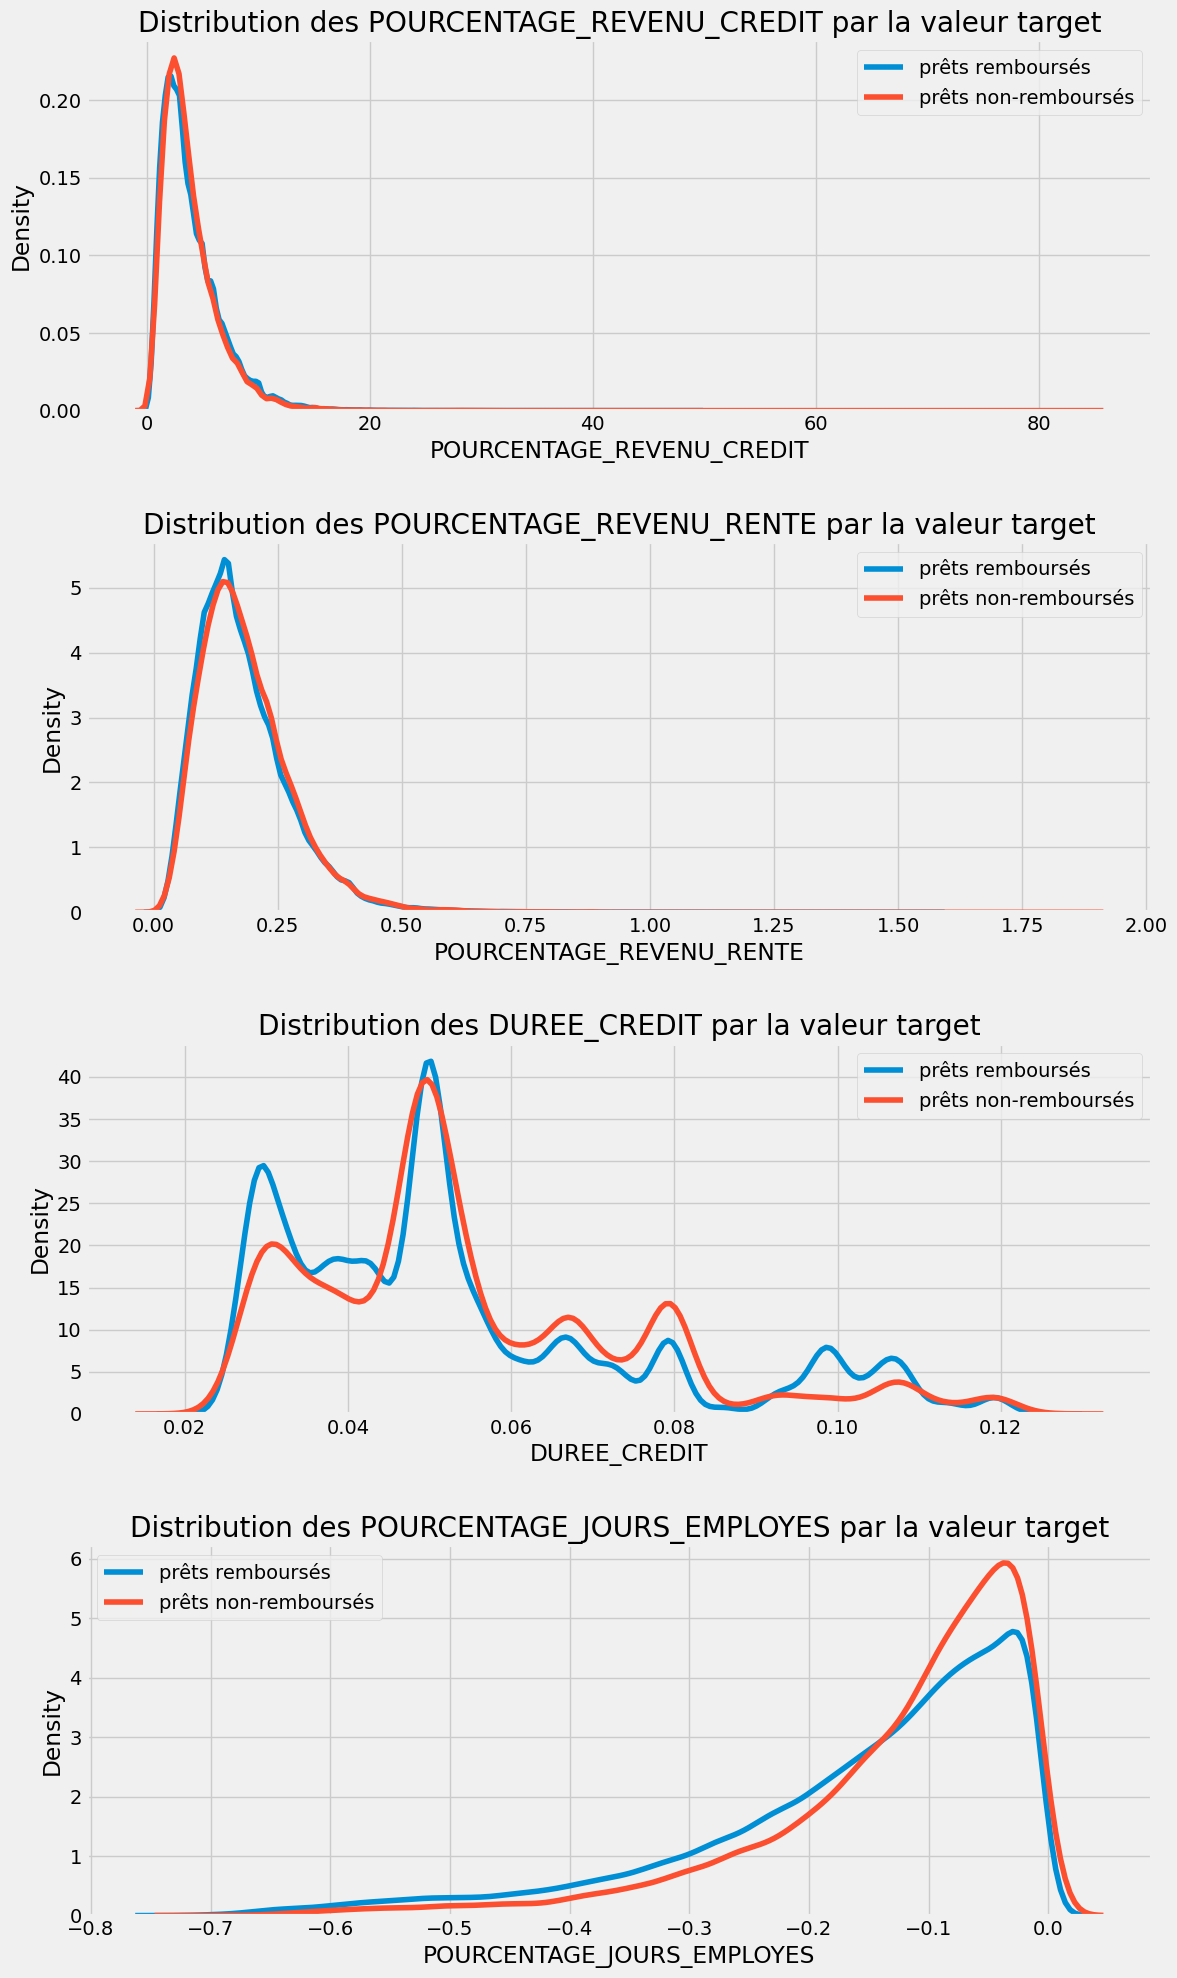

In [ ]:
plt.figure(figsize=(12, 20))
# itérer à travers les nouvelles features
for i, feature in enumerate(['POURCENTAGE_REVENU_CREDIT', 'POURCENTAGE_REVENU_RENTE', 'DUREE_CREDIT', 'POURCENTAGE_JOURS_EMPLOYES']):

    # créer un nouveau sous-graphe pour chaque source
    plt.subplot(4, 1, i + 1)
    # plot prêts remboursés
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label='prêts remboursés')
    # plot prêts non-remboursés
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label='prêts non-remboursés')

    # Annotations des labels
    plt.title('Distribution des {} par la valeur target'.format(feature))
    plt.xlabel('{}'.format(feature))
    plt.ylabel('Density')

    # Ajout de la légende
    plt.legend()

plt.tight_layout(h_pad=2.5)


Il est difficile de dire à l'avance si ces nouvelles fonctionnalités seront utiles. Le seul moyen d'en être sûr est de les essayer !

## Feature engineering

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

In [ ]:
# Calculer la corrélation entre les features et la variable target des données app_train_domain
correlation_matrix = app_train_domain.sample(frac=0.5).corr()
correlation_with_target = correlation_matrix['TARGET'].abs().sort_values(ascending=False)

In [ ]:
correlation_matrix.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  \
SK_ID_CURR               1.000               0.001         0.002   
NAME_CONTRACT_TYPE       0.001               1.000         0.001   
FLAG_OWN_CAR             0.002               0.001         1.000   
FLAG_OWN_REALTY          0.000               0.065        -0.003   
CNT_CHILDREN            -0.005               0.028         0.102   

                    FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  \
SK_ID_CURR                    0.000        -0.005             0.004   
NAME_CONTRACT_TYPE            0.065         0.028            -0.009   
FLAG_OWN_CAR                 -0.003         0.102             0.178   
FLAG_OWN_REALTY               1.000        -0.006             0.005   
CNT_CHILDREN                 -0.006         1.000             0.027   

                    AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR               0.003        0.002            0.004   
NAME_CONTRACT_TYPE      -0.221       -0.242           -0.186   
FLAG_OWN_CAR             0.116        0.142            0.120   
FLAG_OWN_REALTY         -0.037       -0.004           -0.044   
CNT_CHILDREN             0.002        0.023           -0.001   

                    REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                               0.001       0.002          0.001   
NAME_CONTRACT_TYPE                       0.029      -0.089          0.037   
FLAG_OWN_CAR                             0.041      -0.129          0.021   
FLAG_OWN_REALTY                          0.017       0.122         -0.030   
CNT_CHILDREN                            -0.025      -0.332          0.061   

                    DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
SK_ID_CURR                     -0.000           -0.001       -0.004   
NAME_CONTRACT_TYPE              0.022            0.056        0.014   
FLAG_OWN_CAR                    0.087            0.014          NaN   
FLAG_OWN_REALTY                -0.028            0.006       -0.002   
CNT_CHILDREN                    0.184           -0.026        0.005   

                    FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
SK_ID_CURR               0.004          -0.003           -0.001   
NAME_CONTRACT_TYPE       0.001           0.056           -0.034   
FLAG_OWN_CAR            -0.004           0.155            0.010   
FLAG_OWN_REALTY         -0.002          -0.072           -0.112   
CNT_CHILDREN             0.001           0.242            0.053   

                    FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
SK_ID_CURR                     0.001       0.003      -0.002           -0.006   
NAME_CONTRACT_TYPE            -0.101      -0.023      -0.012            0.008   
FLAG_OWN_CAR                  -0.002      -0.010       0.030            0.152   
FLAG_OWN_REALTY                0.009      -0.039       0.029            0.003   
CNT_CHILDREN                   0.001      -0.032       0.022            0.879   

                    REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
SK_ID_CURR                        -0.001                       -0.001   
NAME_CONTRACT_TYPE                -0.023                       -0.024   
FLAG_OWN_CAR                      -0.021                       -0.020   
FLAG_OWN_REALTY                    0.001                        0.002   
CNT_CHILDREN                       0.023                        0.022   

                    HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
SK_ID_CURR                           -0.000                      -0.001   
NAME_CONTRACT_TYPE                    0.036                       0.018   
FLAG_OWN_CAR                          0.010                      -0.001   
FLAG_OWN_REALTY                      -0.102                      -0.035   
CNT_CHILDREN                         -0.007                      -0.014   

                    REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
SK_ID_CURR                              -0.001    

In [ ]:
correlation_with_target

TARGET                                1.000
EXT_SOURCE_3                          0.179
EXT_SOURCE_2                          0.160
EXT_SOURCE_1                          0.158
DAYS_BIRTH                            0.080
                                       ... 
FLAG_EMAIL                            0.000
OCCUPATION_TYPE_Realty agents         0.000
ORGANIZATION_TYPE_Trade: type 5       0.000
ORGANIZATION_TYPE_Industry: type 10   0.000
FLAG_DOCUMENT_12                        NaN
Name: TARGET, Length: 245, dtype: float64

In [ ]:
# Définir le nombre de top features en corrélation directe que l'on souhaite sélectionner
top_n_features = 100    # Ajustez ce nombre si nécessaire

# Selection des top features correlées
selected_features = correlation_with_target.head(top_n_features).index.tolist()

# Créer un nouveau DataFrame avec seulement les features correlées
train_selected_features = app_train_domain[selected_features]

In [ ]:
len(selected_features)

100

In [ ]:
print('Taille du nouveau dataframe (train_selected_features) :', train_selected_features.shape)
print( )
train_selected_features.head()

Taille du nouveau dataframe (train_selected_features) : (307511, 100)



TARGET  EXT_SOURCE_3  EXT_SOURCE_2  EXT_SOURCE_1  DAYS_BIRTH  \
0       1         0.139         0.263         0.083        9461   
1       0           NaN         0.622         0.311       16765   
2       0         0.730         0.556           NaN       19046   
3       0           NaN         0.650           NaN       19005   
4       0           NaN         0.323           NaN       19932   

   DAYS_EMPLOYED  POURCENTAGE_JOURS_EMPLOYES  NAME_INCOME_TYPE_Working  \
0       -637.000                      -0.067                         1   
1      -1188.000                      -0.071                         0   
2       -225.000                      -0.012                         1   
3      -3039.000                      -0.160                         1   
4      -3038.000                      -0.152                         1   

   REGION_RATING_CLIENT_W_CITY  REGION_RATING_CLIENT  DAYS_LAST_PHONE_CHANGE  \
0                            2                     2               -1134.000   
1                            1                     1                -828.000   
2                            2                     2                -815.000   
3                            2                     2                -617.000   
4                            2                     2               -1106.000   

   CODE_GENDER_M  CODE_GENDER_F  NAME_EDUCATION_TYPE_Higher education  \
0              1              0                                     0   
1              0              1                                     1   
2              1              0                                     0   
3              0              1                                     0   
4              1              0                                     0   

   REG_CITY_NOT_WORK_CITY  DAYS_ID_PUBLISH  NAME_INCOME_TYPE_Pensioner  \
0                       0            -2120                           0   
1                       0             -291                           0   
2                       0            -2531                           0   
3                       0            -2437                           0   
4                       1            -3458                           0   

   FLAG_EMP_PHONE  ORGANIZATION_TYPE_XNA  DAYS_EMPLOYED_ANOM  \
0               1                      0               False   
1               1                      0               False   
2               1                      0               False   
3               1                      0               False   
4               1                      0               False   

   NAME_EDUCATION_TYPE_Secondary / secondary special  REG_CITY_NOT_LIVE_CITY  \
0                                                  1                       0   
1                                                  0                       0   
2                                                  1                       0   
3                                                  1                       0   
4                                                  1                       0   

   FLAG_DOCUMENT_3  DAYS_REGISTRATION  OWN_CAR_AGE  OCCUPATION_TYPE_Laborers  \
0                1          -3648.000          NaN                         1   
1                1          -1186.000          NaN                         0   
2                0          -4260.000       26.000                         1   
3                1          -9833.000          NaN                         1   
4                0          -4311.000          NaN                         0   

   EMERGENCYSTATE_MODE_No  AMT_GOODS_PRICE  FLOORSMAX_AVG  FLOORSMAX_MEDI  \
0                       1       351000.000          0.083           0.083   
1                       1      1129500.000          0.292           0.292   
2                       0       135000.000            NaN             NaN   
3                       0       297000.000            NaN             NaN   
4                       0       513000.000            NaN 

In [ ]:
X = train_selected_features.drop(columns=['TARGET'])  # Features
y = train_selected_features['TARGET']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Noms des features
features = list(X.columns)

# Imputation des valeurs manquantes par la médiane
imputer = SimpleImputer(strategy='median')

# Mettre à l'échelle chaque caractéristique de 0 à 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Ajustement sur les données d'entraînement
imputer.fit(X)

SimpleImputer(strategy='median')

In [ ]:
# Transformer et scaler X
X = imputer.transform(X)

scaler.fit(X)

X = scaler.transform(X)

print('Training data shape: ', X.shape)

Training data shape:  (307511, 99)


In [ ]:
X

array([[0.15505445, 0.30754227, 0.07221502, ..., 0.        , 0.        ,
        0.3778607 ],
       [0.59716311, 0.72777309, 0.31293267, ..., 0.        , 1.        ,
        0.053985  ],
       [0.81413048, 0.65018979, 0.51831772, ..., 0.        , 0.        ,
        0.27284329],
       ...,
       [0.24381478, 0.62657536, 0.76936959, ..., 0.        , 1.        ,
        0.21655733],
       [0.7375872 , 0.60136022, 0.51831772, ..., 0.        , 0.        ,
        0.31770901],
       [0.12663023, 0.82873586, 0.75927943, ..., 0.        , 0.        ,
        0.49526743]])

>> **Convertir les tableaux numpy X en DataFrames**

In [ ]:
# Supprimer la colonne 'TARGET' pour la transformation
X_data = train_selected_features.drop(columns=['TARGET'])

print('taille de app_train', X_data.shape)

taille de app_train (307511, 99)


In [ ]:
# Convertir les tableaux numpy X en DataFrames
X = pd.DataFrame(X, columns=X_data.columns)
print('X.shape :', X.shape)
print( )
X

X.shape : (307511, 99)



EXT_SOURCE_3  EXT_SOURCE_2  EXT_SOURCE_1  DAYS_BIRTH  DAYS_EMPLOYED  \
0              0.155         0.308         0.072       0.111          0.964   
1              0.597         0.728         0.313       0.523          0.934   
2              0.814         0.650         0.518       0.651          0.987   
3              0.597         0.761         0.518       0.649          0.830   
4              0.597         0.377         0.518       0.701          0.830   
...              ...           ...           ...         ...            ...   
307506         0.597         0.797         0.138       0.104          0.987   
307507         0.597         0.136         0.518       0.749          0.908   
307508         0.244         0.627         0.769       0.421          0.558   
307509         0.738         0.601         0.518       0.252          0.733   
307510         0.127         0.829         0.759       0.528          0.930   

        POURCENTAGE_JOURS_EMPLOYES  NAME_INCOME_TYPE_Working  \
0                            0.908                     1.000   
1                            0.903                     0.000   
2                            0.984                     1.000   
3                            0.781                     1.000   
4                            0.791                     1.000   
...                            ...                       ...   
307506                       0.965                     1.000   
307507                       0.837                     0.000   
307508                       0.274                     1.000   
307509                       0.451                     0.000   
307510                       0.897                     0.000   

        REGION_RATING_CLIENT_W_CITY  REGION_RATING_CLIENT  \
0                             0.500                 0.500   
1                             0.000                 0.000   
2                             0.500                 0.500   
3                             0.500                 0.500   
4                             0.500                 0.500   
...                             ...                   ...   
307506                        0.000                 0.000   
307507                        0.500                 0.500   
307508                        1.000                 1.000   
307509                        0.500                 0.500   
307510                        0.000                 0.000   

        DAYS_LAST_PHONE_CHANGE  CODE_GENDER_M  CODE_GENDER_F  \
0                        0.736          1.000          0.000   
1                        0.807          0.000          1.000   
2                        0.810          1.000          0.000   
3                        0.856          0.000          1.000   
4                        0.742          1.000          0.000   
...                        ...            ...            ...   
307506                   0.936          1.000          0.000   
307507                   1.000          0.000          1.000   
307508                   0.555          0.000          1.000   
307509                   0.925          0.000          1.000   
307510                   0.817          0.000          1.000   

        NAME_EDUCATION_TYPE_Higher education  REG_CITY_NOT_WORK_CITY  \
0                                      0.000                   0.000   
1                                      1.000                   0.000   
2                                      0.000                   0.000   
3                                      0.000                   0.000   
4                                      0.000                   1.000   
...                                      ...                     ...   
307506                                 0.000                   0.000   
307507                                 0.000                   0.000   
307508                                 1.000                   1.000   
307509                                 0.000                   1.000

In [ ]:
# Rétablir l'index client 'SK_ID_CURR'
X['SK_ID_CURR'] = app_train_domain['SK_ID_CURR']
X.set_index('SK_ID_CURR', inplace=True)

print('taille de X', X.shape)
print( )
X

taille de X (307511, 99)



EXT_SOURCE_3  EXT_SOURCE_2  EXT_SOURCE_1  DAYS_BIRTH  \
SK_ID_CURR                                                         
100002             0.155         0.308         0.072       0.111   
100003             0.597         0.728         0.313       0.523   
100004             0.814         0.650         0.518       0.651   
100006             0.597         0.761         0.518       0.649   
100007             0.597         0.377         0.518       0.701   
...                  ...           ...           ...         ...   
456251             0.597         0.797         0.138       0.104   
456252             0.597         0.136         0.518       0.749   
456253             0.244         0.627         0.769       0.421   
456254             0.738         0.601         0.518       0.252   
456255             0.127         0.829         0.759       0.528   

            DAYS_EMPLOYED  POURCENTAGE_JOURS_EMPLOYES  \
SK_ID_CURR                                              
100002              0.964                       0.908   
100003              0.934                       0.903   
100004              0.987                       0.984   
100006              0.830                       0.781   
100007              0.830                       0.791   
...                   ...                         ...   
456251              0.987                       0.965   
456252              0.908                       0.837   
456253              0.558                       0.274   
456254              0.733                       0.451   
456255              0.930                       0.897   

            NAME_INCOME_TYPE_Working  REGION_RATING_CLIENT_W_CITY  \
SK_ID_CURR                                                          
100002                         1.000                        0.500   
100003                         0.000                        0.000   
100004                         1.000                        0.500   
100006                         1.000                        0.500   
100007                         1.000                        0.500   
...                              ...                          ...   
456251                         1.000                        0.000   
456252                         0.000                        0.500   
456253                         1.000                        1.000   
456254                         0.000                        0.500   
456255                         0.000                        0.000   

            REGION_RATING_CLIENT  DAYS_LAST_PHONE_CHANGE  CODE_GENDER_M  \
SK_ID_CURR                                                                
100002                     0.500                   0.736          1.000   
100003                     0.000                   0.807          0.000   
100004                     0.500                   0.810          1.000   
100006                     0.500                   0.856          0.000   
100007                     0.500                   0.742          1.000   
...                          ...                     ...            ...   
456251                     0.000                   0.936          1.000   
456252                     0.500                   1.000          0.000   
456253                     1.000                   0.555          0.000   
456254                     0.500                   0.925          0.000   
456255                     0.000                   0.817          0.000   

            CODE_GENDER_F  NAME_EDUCATION_TYPE_Higher education  \
SK_ID_CURR                                                        
100002              0.000                                 0.000   
100003              1.000                                 1.000   
100004              0.000                                 0.000   
100006              1.000                                 0.000   
100007              0.000                                 0.000   
...                   ...                 

In [ ]:
# Nettoyer et prétraiter les noms des features
def clean_feature_names(df):
    df.columns = df.columns.str.strip()  # Supprimer les espaces blancs de début et de fin
    df.columns = df.columns.str.replace(' ', '_')  # Remplacer les espaces par des traits de soulignement
    df.columns = df.columns.str.replace('[^a-zA-Z0-9_]', '', regex=True)  # Supprimer les caractères non alphanumériques et non accentués
    df.columns = df.columns.str.lower()  # Convertir les noms en minuscules (facultatif)

In [ ]:
# Nettoyer les noms des features dans le dataset
clean_feature_names(X)

In [ ]:
X

ext_source_3  ext_source_2  ext_source_1  days_birth  \
SK_ID_CURR                                                         
100002             0.155         0.308         0.072       0.111   
100003             0.597         0.728         0.313       0.523   
100004             0.814         0.650         0.518       0.651   
100006             0.597         0.761         0.518       0.649   
100007             0.597         0.377         0.518       0.701   
...                  ...           ...           ...         ...   
456251             0.597         0.797         0.138       0.104   
456252             0.597         0.136         0.518       0.749   
456253             0.244         0.627         0.769       0.421   
456254             0.738         0.601         0.518       0.252   
456255             0.127         0.829         0.759       0.528   

            days_employed  pourcentage_jours_employes  \
SK_ID_CURR                                              
100002              0.964                       0.908   
100003              0.934                       0.903   
100004              0.987                       0.984   
100006              0.830                       0.781   
100007              0.830                       0.791   
...                   ...                         ...   
456251              0.987                       0.965   
456252              0.908                       0.837   
456253              0.558                       0.274   
456254              0.733                       0.451   
456255              0.930                       0.897   

            name_income_type_working  region_rating_client_w_city  \
SK_ID_CURR                                                          
100002                         1.000                        0.500   
100003                         0.000                        0.000   
100004                         1.000                        0.500   
100006                         1.000                        0.500   
100007                         1.000                        0.500   
...                              ...                          ...   
456251                         1.000                        0.000   
456252                         0.000                        0.500   
456253                         1.000                        1.000   
456254                         0.000                        0.500   
456255                         0.000                        0.000   

            region_rating_client  days_last_phone_change  code_gender_m  \
SK_ID_CURR                                                                
100002                     0.500                   0.736          1.000   
100003                     0.000                   0.807          0.000   
100004                     0.500                   0.810          1.000   
100006                     0.500                   0.856          0.000   
100007                     0.500                   0.742          1.000   
...                          ...                     ...            ...   
456251                     0.000                   0.936          1.000   
456252                     0.500                   1.000          0.000   
456253                     1.000                   0.555          0.000   
456254                     0.500                   0.925          0.000   
456255                     0.000                   0.817          0.000   

            code_gender_f  name_education_type_higher_education  \
SK_ID_CURR                                                        
100002              0.000                                 0.000   
100003              1.000                                 1.000   
100004              0.000                                 0.000   
100006              1.000                                 0.000   
100007              0.000                                 0.000   
...                   ...                 

In [ ]:
# Séparez les données en ensembles d'apprentissage (train) et de test (test) pour les caractéristiques et les étiquettes
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print('taille de X_train :', X_train.shape)
print( )
print('taille de y_train :', y_train.shape)
print( )
print('taille de X_test :', X_test.shape)
print( )
print('taille de y_test :', y_test.shape)

taille de X_train : (246008, 99)

taille de y_train : (246008,)

taille de X_test : (61503, 99)

taille de y_test : (61503,)


In [ ]:
# Calculer le nombre d'échantillons souhaité pour chaque classe
desired_samples_class_0 = np.sum(y_train == 1) * 2  # Ratio de 2:1 avec la classe 1
desired_samples_class_1 = np.sum(y_train == 1)  # Conserver le même nombre d'échantillons pour la classe 1

# Créer un dictionnaire de stratégie d'échantillonnage personnalisé pour RandomUnderSampler
sampling_strategy_under = {
    0: desired_samples_class_0,
    1: desired_samples_class_1
}

# Mise en place de l'apprentissage automatique

In [ ]:
# Importons les librairies communes aux deux modèles

from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from joblib import Parallel, delayed
import multiprocessing
import pickle

> ## Modèle : **LightGBM**

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
# Définir la grille de paramètres pour l'ajustement des hyperparamètres de LightGBM
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [6, 8, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],
    'classifier__min_child_samples': [20, 30, 40],
    'classifier__num_leaves': [20, 30, 40]  # Ajoutez num_leaves à la grille de recherche, Cela permettra à LightGBM de prendre en compte le nombre de feuilles pendant la recherche des hyperparamètres
}


In [ ]:
## créons un échantillonneur aléatoire pour la sous-représentation des données, où la classe majoritaire sera réduite aléatoirement pour équilibrer les classes dans l'ensemble de données.
# créons une instance de la classe RandomUnderSampler
random_undersampler = RandomUnderSampler(sampling_strategy=sampling_strategy_under, random_state=42)

In [ ]:
# appliquons la méthode d'échantillonnage sous-représenté (undersampling) à nos données d'entraînement, en générant de nouveaux ensembles de données équilibrés
X_train_resampled, y_train_resampled = random_undersampler.fit_resample(X_train, y_train)

In [ ]:
## créons un classificateur LGBM avec une graine aléatoire fixée et une pondération spécifique pour les classes,
# le but visé étant de mieux gérer un déséquilibre de classes dans les données d'entraînement.
lgb_classifier = lgb.LGBMClassifier(random_state=42, class_weight={0: 1, 1: 2})

In [ ]:
# créons un objet SMOTE
smote = SMOTE(sampling_strategy=0.7, random_state=42)

In [ ]:
# Créons le pipeline avec le rééchantillonnage et le classificateur
pipeline = ImbPipeline([
     ('oversampler', smote),
    ('classifier', lgb_classifier)
])

In [ ]:
#  Définissons la fonction de notation AUC-ROC
scoring = make_scorer(roc_auc_score, greater_is_better=True)

In [ ]:
num_cores = multiprocessing.cpu_count() # pour obtenir le nombre de cpu

In [ ]:
# Créons l'objet RandomizedSearchCV
random_search_lgbm = RandomizedSearchCV(
    pipeline, param_distributions=param_grid, n_iter=10, scoring=scoring, refit=True, cv=5, verbose=1, random_state=42, n_jobs=num_cores
)

In [ ]:
# Entrainement du modèle
random_search_lgbm.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Number of positive: 27826, number of negative: 39752
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18125
[LightGBM] [Info] Number of data points in the train set: 67578, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.583330 -> initscore=0.336458
[LightGBM] [Info] Start training from score 0.336458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('oversampler',
                                              SMOTE(random_state=42,
                                                    sampling_strategy=0.7)),
                                             ('classifier',
                                              LGBMClassifier(class_weight={0: 1,
                                                                           1: 2},
                                                             random_state=42))]),
                   n_jobs=2,
                   param_distributions={'classifier__colsample_bytree': [0.8,
                                                                         0.9,
                                                                         1.0],
                                        'classifier__learning_rate': [0.01, 0.1,
                                                                      0.2],
                                        'classifier__max_depth': [6, 8, 10],
                                        'classifier__min_child_samples': [20,
                                                                          30,
                                                                          40],
                                        'classifier__n_estimators': [100, 200,
                                                                     300],
                                        'classifier__num_leaves': [20, 30, 40],
                                        'classifier__subsample': [0.8, 0.9,
                                                                  1.0]},
                   random_state=42, scoring=make_scorer(roc_auc_score),
                   verbose=1)

>> Enregistrement et export du fichier d'entrainement random_search dans un fichier .pkl

In [ ]:
'''mon_fichier_random_search_lgbm = "lgbm.pkl"

with open(mon_fichier_random_search_lgbm, 'wb') as fichier_random_search_lgbm:
    pickle.dump(random_search_lgbm, fichier_random_search_lgbm)

print(f"Objet RandomizedSearchCV enregistré sous {fichier_random_search_lgbm}")'''

'mon_fichier_random_search_lgbm = "lgbm.pkl"\n\nwith open(mon_fichier_random_search_lgbm, \'wb\') as fichier_random_search_lgbm:\n    pickle.dump(random_search_lgbm, fichier_random_search_lgbm)\n\nprint(f"Objet RandomizedSearchCV enregistré sous {fichier_random_search_lgbm}")'

>> Chargement de l'objet RandomizedSearchCV entrainé depuis le fichier .pkl exporté

In [ ]:
'''# Chargement de l'objet Gridsearch entrainé depuis le fichier .pkl exporté
mon_fichier_random_search_lgbm = "lgbm.pkl"

with open(mon_fichier_random_search_lgbm, 'rb') as fichier_random_search_lgbm:
    random_search_lgbm = pickle.load(fichier_random_search_lgbm)'''

'# Chargement de l\'objet Gridsearch entrainé depuis le fichier .pkl exporté\nmon_fichier_random_search_lgbm = "lgbm.pkl"\n\nwith open(mon_fichier_random_search_lgbm, \'rb\') as fichier_random_search_lgbm:\n    random_search_lgbm = pickle.load(fichier_random_search_lgbm)'

In [ ]:
# Obtenir les meilleurs paramètres et le meilleur estimateur
best_params = random_search_lgbm.best_params_
best_estimator = random_search_lgbm.best_estimator_

print("Meilleurs paramètres:", best_params)
print( )
print("Meilleur estimateur:", best_estimator)

Meilleurs paramètres: {'classifier__subsample': 1.0, 'classifier__num_leaves': 30, 'classifier__n_estimators': 300, 'classifier__min_child_samples': 40, 'classifier__max_depth': 8, 'classifier__learning_rate': 0.1, 'classifier__colsample_bytree': 0.9}

Meilleur estimateur: Pipeline(steps=[('oversampler', SMOTE(random_state=42, sampling_strategy=0.7)),
                ('classifier',
                 LGBMClassifier(class_weight={0: 1, 1: 2}, colsample_bytree=0.9,
                                max_depth=8, min_child_samples=40,
                                n_estimators=300, num_leaves=30,
                                random_state=42))])


In [ ]:
# Évaluons le meilleur estimateur sur les données de test
y_pred = best_estimator.predict(X_test)

In [ ]:
# Évaluons le meilleur estimateur sur les données de test
y_pred_prob = best_estimator.predict_proba(X_test)[:, 1]  # Prédire les probabilités pour la classe 1

In [ ]:
# Calculons l'AUC ROC sur les données de test
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC AUC sur les données de test:", roc_auc)

ROC AUC sur les données de test: 0.7611439347825881


>> Matrice de Confusion

En supposant que nous ayons défini 'y_test' ('labels réels') et 'y_pred' ('labels prédits'), nous obtiendrions les résultats suivants :



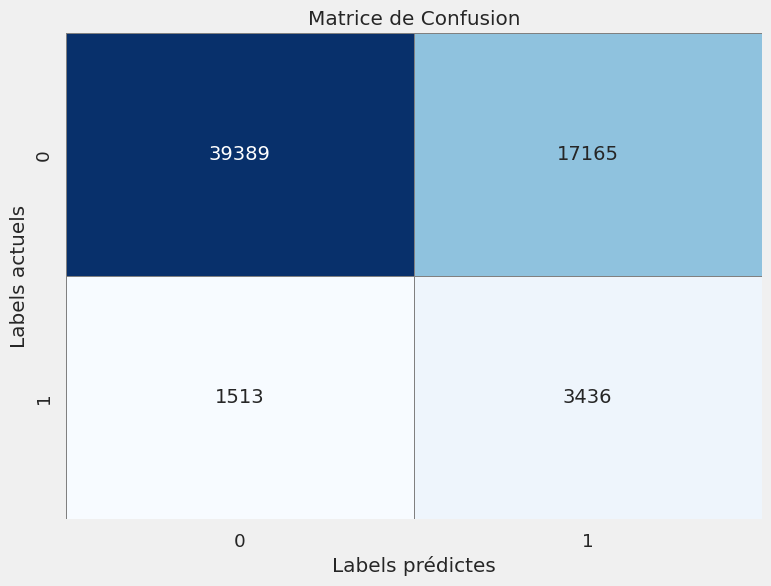

In [ ]:
from sklearn.metrics import confusion_matrix

print("En supposant que nous ayons défini 'y_test' ('labels réels') et 'y_pred' ('labels prédits'), nous obtiendrions les résultats suivants :")
print( )

# Compiler la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Créons une heatmap Seaborn pour la visualisation
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Ajuster la taille de la police d'écriture si nécessaire
sns.heatmap(
    cm,
    annot=True,  # Annoter les cellules avec les valeurs numériques
    fmt="d",     # Format des valeurs annotées sous forme d'entiers
    cmap="Blues",  # Colormap pour la heatmap
    cbar=False,   # cché la barre de couleur
    annot_kws={"size": 14},  # Ajuster la taille de la police des annotations
    linewidths=0.5,  # Ajouter une ligne entre les cellules
    linecolor="gray"  # Couleur des lignes entre les cellules
)

# Définir les labels et les titres des axes
plt.xlabel("Labels prédictes")
plt.ylabel("Labels actuels")
plt.title("Matrice de Confusion")

# Visualiser le plot
plt.show()

In [ ]:
# Calculer la distribution en pourcentage dans les valeurs predictent
unique_elements, counts = np.unique(y_pred, return_counts=True)
percentage_distribution = (counts / len(y_pred)) * 100

# Afficher la distribution en pourcentage
for element, percentage in zip(unique_elements, percentage_distribution):
    print(f'Élément {element}: {percentage:.2f}%')

Élément 0: 66.50%
Élément 1: 33.50%


>> Rapport de classification

In [ ]:
from sklearn.metrics import classification_report

print("En supposant que nous ayons défini 'y_test' ('labels réels') et 'y_pred' ('labels prédits')")
print( )

# Générons le rapport de classification
report = classification_report(y_test, y_pred)

# Affichons le rapport
print(report)

En supposant que nous ayons défini 'y_test' ('labels réels') et 'y_pred' ('labels prédits')

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56554
           1       0.17      0.69      0.27      4949

    accuracy                           0.70     61503
   macro avg       0.56      0.70      0.54     61503
weighted avg       0.90      0.70      0.76     61503



>> Courbe ROC

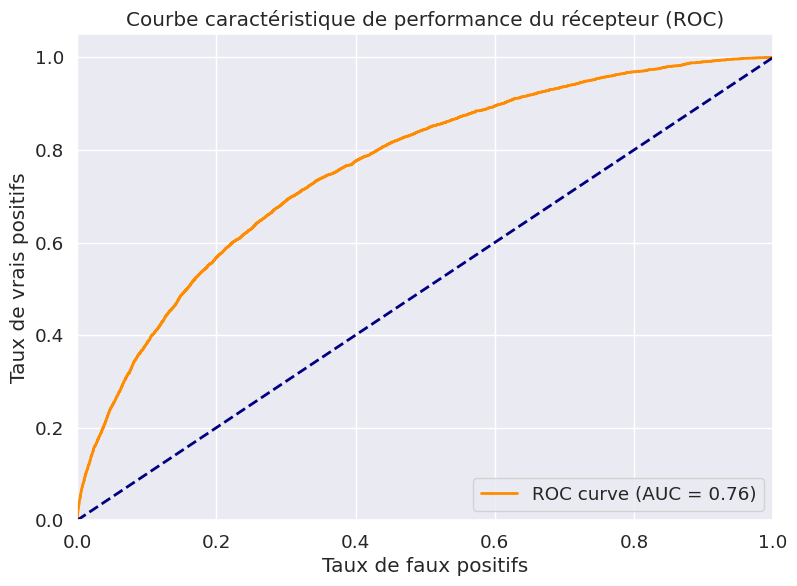

In [ ]:
from sklearn.metrics import roc_curve

# En supposant que nous ayons défini 'y_test' ('labels réels') et 'y_pred' ('labels prédits')

# Calculons ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculons ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Affichons la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe caractéristique de performance du récepteur (ROC)')
plt.legend(loc='lower right')
plt.show()

>> Courbe Précision-Rappel

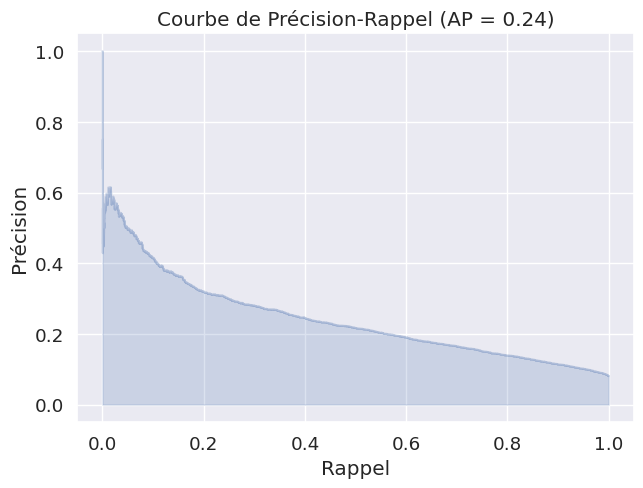

In [ ]:
# traçons la courbe de précision-rappel (Precision-Recall Curve) pour évaluer les performances d'un modèle de classification binaire.
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de Précision-Rappel (AP = %0.2f)' % average_precision)
plt.show()  # Ajout de cette ligne pour afficher le graphe

>> Importance des caractéristiques dans les prédictions du modèle (SHAP - Barres)

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 6.9 MB/s eta 0:00:00


In [ ]:
import shap

In [ ]:
# créons l'objet explainer
explainer = shap.TreeExplainer(best_estimator["classifier"])

In [ ]:
# calculons les valeurs SHAP pour toutes les observations de notre ensemble de test
shap_values = explainer.shap_values(X_test[:])

Ce calcul va nous permettre ainsi d'expliquer comment chaque caractéristique contribue aux prédictions du modèle pour cet ensemble spécifique de données de test.

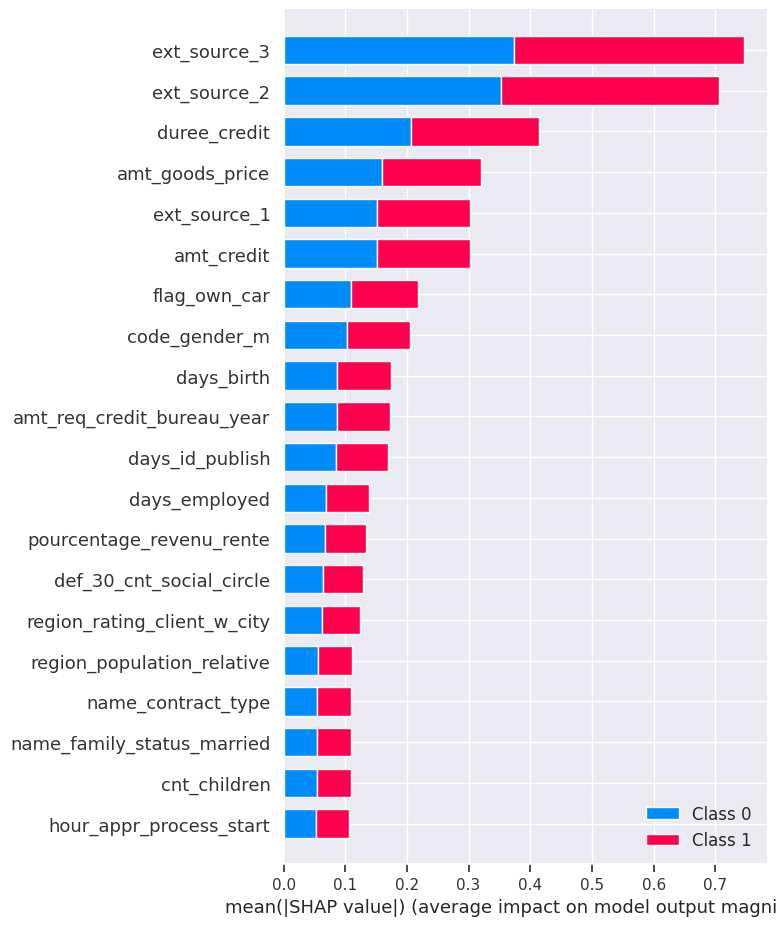

In [ ]:
# Visualisons l'importance des caractéristiques dans notre modèle
shap.summary_plot(shap_values, X_test[:], plot_type="bar")

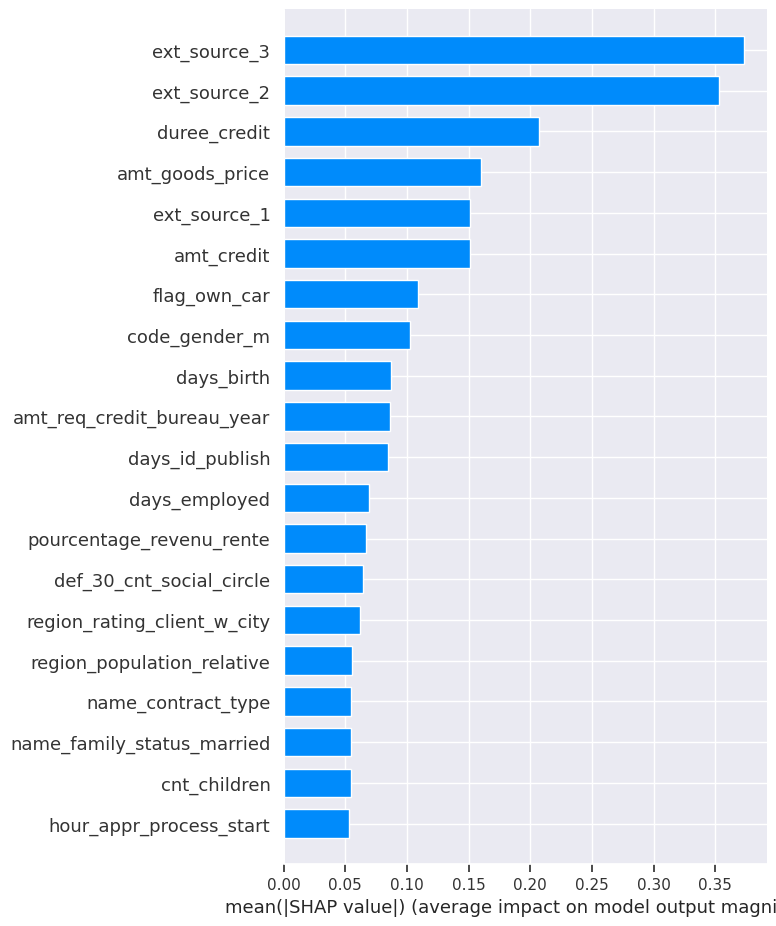

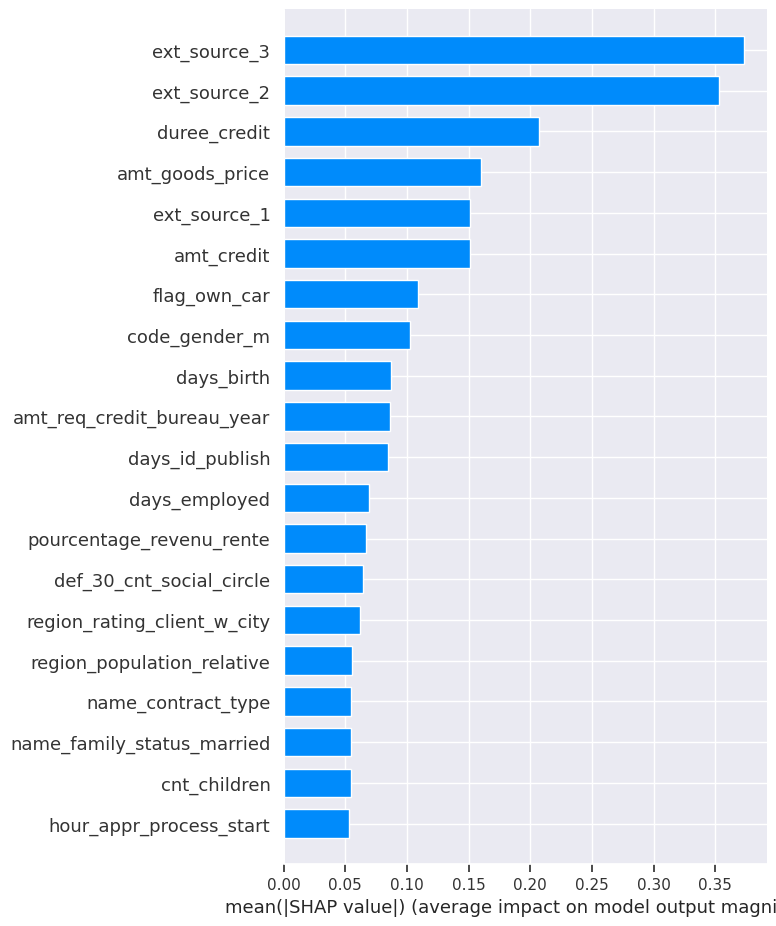

In [ ]:
# En supposant que 'shap_values' est une liste de valeurs SHAP pour chaque sortie
for i in range(len(shap_values)):
    shap.summary_plot(shap_values[i], X_test, plot_type="bar", class_names=[f"Output {i}"])

>> **Serialisation du modèle**

In [ ]:
# Enregistrez le modèle dans un fichier pickle
mon_modele_entraine = best_estimator

# Spécifiez le chemin complet où enregistrer le modèle
path_best_modele_entraine = "mon_best_modele_entraine_LightGBM.pkl"

# Ouvrir le fichier en mode écriture binaire ('wb' pour pickle)
with open(path_best_modele_entraine, 'wb') as fichier:
    pickle.dump(mon_modele_entraine, fichier)


> ## Modèle : **Régression logistique**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
#from sklearn.model_selection import GridSearchCV

In [ ]:
# Grille de paramètres pour la régression logistique
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10],  # Utilisez 'classifier__C' pour indiquer le paramètre C du classificateur | Inverse de la force de régularisation
    'classifier__penalty': ['l1', 'l2'],  # Spécifiez le type de régularisation pour le classificateur ('l1' pour Lasso, 'l2' pour Ridge)
    'classifier__solver': ['liblinear', 'saga'] # Choisissez l'algorithme de résolution pour optimiser la régularisation
}

In [ ]:
## créons un échantillonneur aléatoire pour la sous-représentation des données, où la classe majoritaire sera réduite aléatoirement pour équilibrer les classes dans l'ensemble de données.
# créons une instance de la classe RandomUnderSampler
random_undersampler = RandomUnderSampler(sampling_strategy=sampling_strategy_under, random_state=42)

In [ ]:
# appliquons la méthode d'échantillonnage sous-représenté (undersampling) à nos données d'entraînement, en générant de nouveaux ensembles de données équilibrés
X_train_resampled, y_train_resampled = random_undersampler.fit_resample(X_train, y_train)

In [ ]:
# Création du classificateur de régression logistique
log_reg = LogisticRegression(random_state=42, class_weight={0: 1, 1: 2})

In [ ]:
# Stratégie de sur-échantillonnage (SMOTE)
smote = SMOTE(sampling_strategy=0.7, random_state=42)

In [ ]:
# Créons le pipeline avec le rééchantillonnage et le classificateur
pipeline = ImbPipeline([
     ('oversampler', smote),
    ('classifier', log_reg)
])

In [ ]:
#  Définissons la fonction de notation AUC-ROC
scoring = make_scorer(roc_auc_score, greater_is_better=True)

In [ ]:
num_cores = multiprocessing.cpu_count() # pour obtenir le nombre de cpu
num_cores

2

In [ ]:
# Création de l'objet RandomizedSearchCV
random_search_regLog = RandomizedSearchCV(
    estimator=pipeline,  # Le modèle que nous utilisons (dans votre cas, il s'agit du pipeline)
    param_distributions=param_grid,  # La distribution des paramètres à explorer
    scoring=scoring,  # La métrique à utiliser pour évaluer les performances
    cv=5,  # Nombre de folds pour la validation croisée
    verbose=1,  # Affichage des messages pendant l'entraînement
    n_jobs=num_cores,  # Nombre de cœurs à utiliser pour l'entraînement
    n_iter=10  # Nombre d'itérations de recherche aléatoire
)


In [ ]:
random_search_regLog.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('oversampler',
                                              SMOTE(random_state=42,
                                                    sampling_strategy=0.7)),
                                             ('classifier',
                                              LogisticRegression(class_weight={0: 1,
                                                                               1: 2},
                                                                 random_state=42))]),
                   n_jobs=2,
                   param_distributions={'classifier__C': [0.001, 0.01, 0.1, 1,
                                                          10],
                                        'classifier__penalty': ['l1', 'l2'],
                                        'classifier__solver': ['liblinear',
                                                               'saga']},
                   scoring=make_scorer(roc_auc_score), verbose=1)

>> Enregistrement et export du fichier d'entrainement random_search dans un fichier .pkl

In [ ]:
'''#mon_fichier_grid_search = "reg_log.best_estimator_.pkl"
mon_fichier_random_search_regLog = "reg_log.pkl"

with open(mon_fichier_random_search_regLog, 'wb') as fichier_random_search_regLog:
    pickle.dump(random_search_regLog, fichier_random_search_regLog)

print(f"Objet RandomizedSearchCV enregistré sous {mon_fichier_random_search_regLog}")'''

'#mon_fichier_grid_search = "reg_log.best_estimator_.pkl"\nmon_fichier_random_search_regLog = "reg_log.pkl"\n\nwith open(mon_fichier_random_search_regLog, \'wb\') as fichier_random_search_regLog:\n    pickle.dump(random_search_regLog, fichier_random_search_regLog)\n\nprint(f"Objet RandomizedSearchCV enregistré sous {mon_fichier_random_search_regLog}")'

>> Chargement de l'objet RandomizedSearchCV entrainé depuis le fichier .pkl exporté

In [ ]:
'''mon_fichier_random_search_regLog = "reg_log.pkl"

with open(mon_fichier_random_search_regLog, 'rb') as fichier_random_search_regLog:
    random_search_regLog = pickle.load(fichier_random_search_regLog)'''

'mon_fichier_random_search_regLog = "reg_log.pkl"\n\nwith open(mon_fichier_random_search_regLog, \'rb\') as fichier_random_search_regLog:\n    random_search_regLog = pickle.load(fichier_random_search_regLog)'

In [ ]:
# Obtenir les meilleurs paramètres et le meilleur estimateur
best_params_regLog = random_search_regLog.best_params_
best_estimator_regLog = random_search_regLog.best_estimator_

print("Meilleurs paramètres:", best_params_regLog)
print( )
print("Meilleur estimateur:", best_estimator_regLog)

Meilleurs paramètres: {'classifier__solver': 'liblinear', 'classifier__penalty': 'l1', 'classifier__C': 10}

Meilleur estimateur: Pipeline(steps=[('oversampler', SMOTE(random_state=42, sampling_strategy=0.7)),
                ('classifier',
                 LogisticRegression(C=10, class_weight={0: 1, 1: 2},
                                    penalty='l1', random_state=42,
                                    solver='liblinear'))])


In [ ]:
# Évaluons le meilleur estimateur sur les données de test
y_pred = best_estimator_regLog.predict(X_test)

In [ ]:
# Évaluons le meilleur estimateur sur les données de test
y_pred_prob = best_estimator_regLog.predict_proba(X_test)[:, 1]  # Prédire les probabilités pour la classe 1

In [ ]:
# Calculons l'AUC ROC sur les données de test
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC AUC sur les données d'essai:", roc_auc)

ROC AUC sur les données d'essai: 0.7466395841394509


>> Matrice de confusion

En supposant que nous ayons défini 'y_test' ('labels réels') et 'y_pred' ('labels prédits'), nous obtiendrions les résultats suivants :



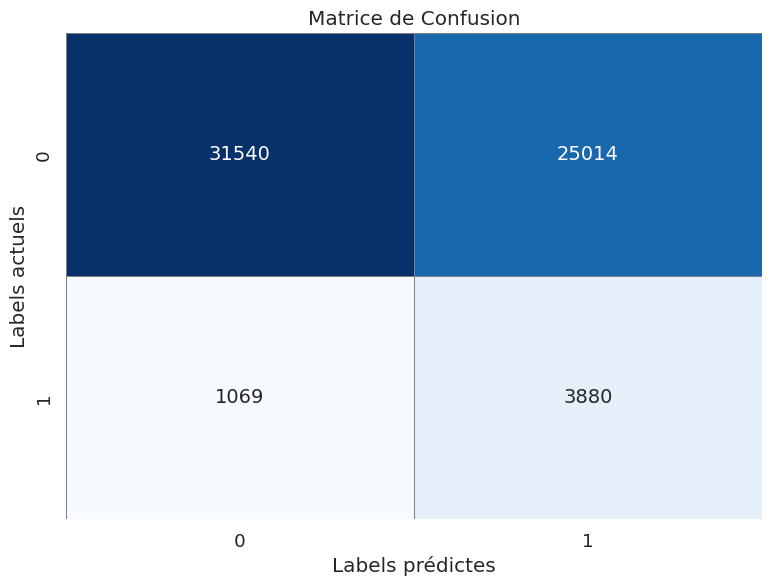

In [ ]:
from sklearn.metrics import confusion_matrix

print("En supposant que nous ayons défini 'y_test' ('labels réels') et 'y_pred' ('labels prédits'), nous obtiendrions les résultats suivants :")
print( )

# Compiler la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Créons une heatmap Seaborn pour la visualisation
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Ajuster la taille de la police d'écriture si nécessaire
sns.heatmap(
    cm,
    annot=True,  # Annoter les cellules avec les valeurs numériques
    fmt="d",     # Format des valeurs annotées sous forme d'entiers
    cmap="Blues",  # Colormap pour la heatmap
    cbar=False,   # cché la barre de couleur
    annot_kws={"size": 14},  # Ajuster la taille de la police des annotations
    linewidths=0.5,  # Ajouter une ligne entre les cellules
    linecolor="gray"  # Couleur des lignes entre les cellules
)

# Définir les labels et les titres des axes
plt.xlabel("Labels prédictes")
plt.ylabel("Labels actuels")
plt.title("Matrice de Confusion")

# Visualiser le plot
plt.show()

In [ ]:
# Calculer la distribution en pourcentage dans les valeurs predictent
unique_elements, counts = np.unique(y_pred, return_counts=True)
percentage_distribution = (counts / len(y_pred)) * 100

# Afficher la distribution en pourcentage
for element, percentage in zip(unique_elements, percentage_distribution):
    print(f'Élément {element}: {percentage:.2f}%')

Élément 0: 53.02%
Élément 1: 46.98%


>> Rapport de classification

In [ ]:
from sklearn.metrics import classification_report

print("En supposant que nous ayons défini 'y_test' ('labels réels') et 'y_pred' ('labels prédits')")
print( )

# Générons le rapport de classification
report = classification_report(y_test, y_pred)

# Affichons le rapport
print(report)

En supposant que nous ayons défini 'y_test' ('labels réels') et 'y_pred' ('labels prédits')

              precision    recall  f1-score   support

           0       0.97      0.56      0.71     56554
           1       0.13      0.78      0.23      4949

    accuracy                           0.58     61503
   macro avg       0.55      0.67      0.47     61503
weighted avg       0.90      0.58      0.67     61503



>> Courbe ROC

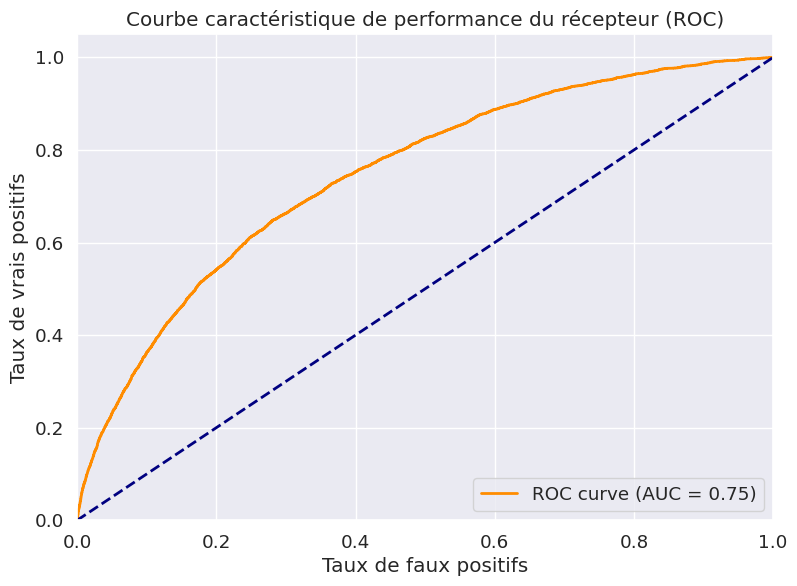

In [ ]:
from sklearn.metrics import roc_curve

# En supposant que nous ayons défini 'y_test' ('labels réels') et 'y_pred' ('labels prédits')

# Calculons ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculons ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Affichons la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe caractéristique de performance du récepteur (ROC)')
plt.legend(loc='lower right')
plt.show()

>> Courbe de Précision-Rappel

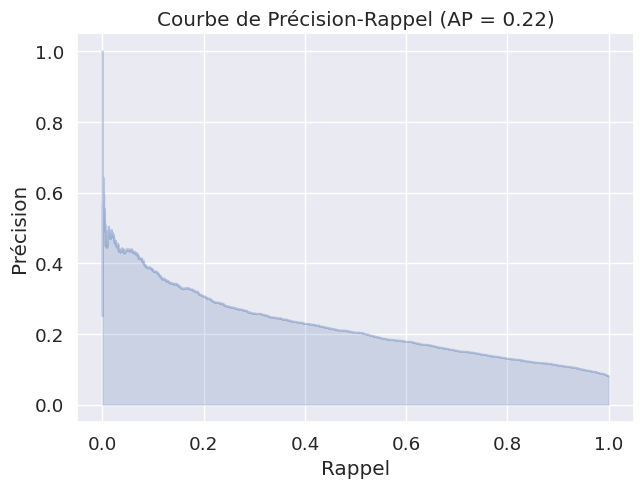

In [ ]:
# traçons la courbe de précision-rappel (Precision-Recall Curve) pour évaluer les performances d'un modèle de classification binaire.
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de Précision-Rappel (AP = %0.2f)' % average_precision)

plt.show()

>> Importance des caractéristiques dans les prédictions du modèle (SHAP - Barres)

In [ ]:
!pip install shap

In [ ]:
import shap

In [ ]:
# Obtenir uniquement le modèle de régression logistique de votre pipeline
#logistic_model = best_estimator_regLog.named_steps['classifier']
logistic_model = best_estimator_regLog['classifier']

# Création de l'objet explainer avec SHAP en utilisant le modèle de régression logistique
explainer = shap.Explainer(logistic_model, X_train_resampled)

In [ ]:
# calculons les valeurs SHAP pour toutes les observations de notre ensemble de test
shap_values = explainer.shap_values(X_test[:])

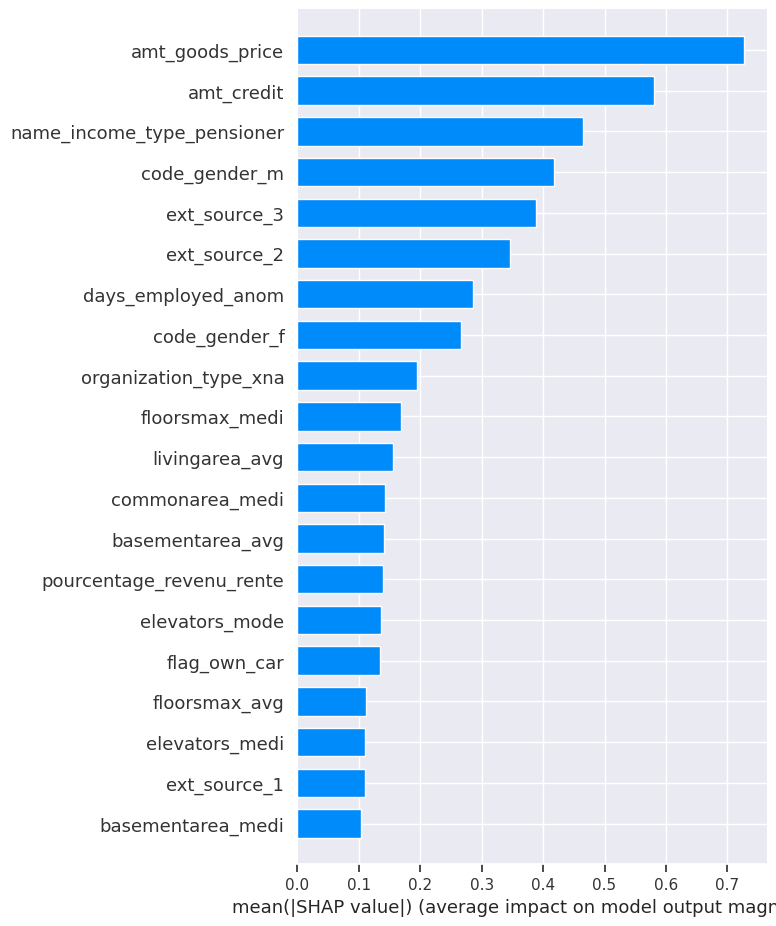

In [ ]:
# Visualisons l'importance des caractéristiques dans notre modèle
shap.summary_plot(shap_values, X_test[:], plot_type="bar")

# Extraire les 50 premières lignes de X_train en vue des opérations a venir

In [ ]:
# Extraire les 50 premières lignes de X_train
sample_top50 = X_train_resampled.iloc[:50]

# Utilisons la méthode to_csv pour sauvegarder le DataFrame en CSV
sample_top50.to_csv('top_50_train.csv')

# Détection de drifting dans le jeu de données train et test

effectuer le drifting que sur les 100 vars selectionnées

transformer le data_test à l'image du data_train (X)

ensuite les comparer pour effectuer l'etude du drift

> ## Preparation des datasets requis

In [ ]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from scipy.stats import ks_2samp

In [ ]:
def preprocess_data(data):
    # Identification des colonnes numériques et catégorielles
    numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

    # Imputation des valeurs numériques avec la stratégie median
    numeric_imputer = SimpleImputer(strategy='median')

    # Imputation des valeurs catégorielles avec la stratégie most_frequent
    categorical_imputer = SimpleImputer(strategy='most_frequent')

    # Création d'un préprocesseur pour les colonnes
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_imputer, numeric_cols),
            ('cat', categorical_imputer, categorical_cols)
        ])

    # Ajustement du préprocesseur sur les données
    preprocessor.fit(data)

    # Transformation des données
    transformed_data = preprocessor.transform(data)

    # Mise à l'échelle des données numériques si nécessaire (MinMaxScaler)
    scaler = MinMaxScaler(feature_range=(0, 1))
    transformed_data[:, :len(numeric_cols)] = scaler.fit_transform(transformed_data[:, :len(numeric_cols)])

    # Création d'un DataFrame avec les données transformées
    dataset = pd.DataFrame(transformed_data, columns=numeric_cols + categorical_cols)

    # Supprimer provisoirement la colonne 'SK_ID_CURR'
    dataset = dataset.drop(columns=['SK_ID_CURR'])

    # Rétablir l'index client 'SK_ID_CURR'
    dataset['SK_ID_CURR'] = data['SK_ID_CURR']
    dataset.set_index('SK_ID_CURR', inplace=True)

    return dataset

>> ### app_train

In [ ]:
# Utilisation de la fonction preprocess_data avec app_train
train_dataset = preprocess_data(app_train)
print('Taille de train_dataset :', train_dataset.shape)
print()
train_dataset.head()

Taille de train_dataset : (307511, 108)



NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                                    
100002                   0.000         0.000            1.000         0.000   
100003                   0.000         0.000            0.000         0.000   
100004                   1.000         1.000            1.000         0.000   
100006                   0.000         0.000            1.000         0.000   
100007                   0.000         0.000            1.000         0.000   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
100002                 0.002       0.090        0.090            0.077   
100003                 0.002       0.312        0.133            0.272   
100004                 0.000       0.022        0.020            0.024   
100006                 0.001       0.067        0.109            0.064   
100007                 0.001       0.117        0.079            0.118   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
100002                           0.256       0.111          0.964   
100003                           0.045       0.523          0.934   
100004                           0.135       0.651          0.987   
100006                           0.107       0.649          0.830   
100007                           0.393       0.701          0.830   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
SK_ID_CURR                                                                
100002                  0.852            0.705        0.099       1.000   
100003                  0.952            0.960        0.099       1.000   
100004                  0.827            0.648        0.286       1.000   
100006                  0.601            0.661        0.099       1.000   
100007                  0.825            0.520        0.099       1.000   

            FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
SK_ID_CURR                                                                  
100002               1.000            0.000             1.000       1.000   
100003               1.000            0.000             1.000       1.000   
100004               1.000            1.000             1.000       1.000   
100006               1.000            0.000             1.000       0.000   
100007               1.000            0.000             1.000       0.000   

            FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR                                                      
100002           0.000            0.000                 0.500   
100003           0.000            0.053                 0.000   
100004           0.000            0.000                 0.500   
100006           0.000            0.053                 0.500   
100007           0.000            0.000                 0.500   

            REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                         
100002                            0.500                    0.435   
100003                            0.000                    0.478   
100004                            0.500                    0.391   
100006                            0.500                    0.739   
100007                            0.500                    0.478   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
100002                           0.000                       0.000   
100003                           0.000                       0.000   
100004                           0.000                       0.000   
100006                           0.000                       0.000   
100007                           0.0

>> ### app_test

In [ ]:
# Utilisation de la fonction preprocess_data avec app_test
test_dataset = preprocess_data(app_test)
print('Taille de test_dataset :', test_dataset.shape)
print()
test_dataset.head()

Taille de test_dataset : (48744, 107)



NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                                    
100001                   0.000         0.000            1.000         0.000   
100005                   0.000         0.000            1.000         0.000   
100013                   0.000         1.000            1.000         0.000   
100028                   0.000         0.000            1.000         0.100   
100038                   0.000         1.000            0.000         0.050   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
100001                 0.025       0.238        0.102            0.184   
100005                 0.016       0.081        0.085            0.061   
100013                 0.040       0.281        0.379            0.266   
100028                 0.066       0.695        0.262            0.695   
100038                 0.035       0.264        0.167            0.264   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
100001                           0.257       0.333          0.867   
100005                           0.492       0.399          0.744   
100013                           0.261       0.289          0.745   
100028                           0.362       0.628          0.893   
100038                           0.135       0.681          0.875   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
SK_ID_CURR                                                                
100001                  0.782            0.872        0.122       1.000   
100005                  0.616            0.744        0.122       1.000   
100013                  0.908            0.448        0.068       1.000   
100028                  0.916            0.337        0.122       1.000   
100038                  0.831            0.329        0.216       1.000   

            FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
SK_ID_CURR                                                                  
100001               1.000            0.000             1.000       0.000   
100005               1.000            0.000             1.000       0.000   
100013               1.000            0.000             1.000       0.000   
100028               1.000            0.000             1.000       1.000   
100038               1.000            1.000             1.000       0.000   

            FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR                                                      
100001           1.000            0.050                 0.500   
100005           0.000            0.050                 0.500   
100013           0.000            0.050                 0.500   
100028           0.000            0.150                 0.500   
100038           0.000            0.100                 0.500   

            REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                                                         
100001                            0.750                    0.783   
100005                            0.750                    0.391   
100013                            0.750                    0.609   
100028                            0.750                    0.478   
100038                            0.750                    0.217   

            REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                                                           
100001                           0.000                       0.000   
100005                           0.000                       0.000   
100013                           0.000                       0.000   
100028                           0.000                       0.000   
100038                           0.0

> ## Pour les features continues

In [ ]:
missing_columns = set(train_dataset.columns) - set(test_dataset.columns)
missing_columns

{'TARGET'}

In [ ]:
train_dataset = train_dataset.drop(columns=['TARGET'])

In [ ]:
# Calcul de la statistique de Kolmogorov-Smirnov pour les features continues
ks_statistique_continues = []
for nom_de_feature in train_dataset.select_dtypes(include=['float64', 'int64']).columns:
    ks_stat, _ = ks_2samp(train_dataset[nom_de_feature], test_dataset[nom_de_feature])
    ks_statistique_continues.append(ks_stat)

In [ ]:
len(ks_statistique_continues)

107

In [ ]:
# Définir un niveau de signification pour le test PSI des features catégorielles
alpha_catégorique = 0.1

In [ ]:
# Définir un niveau de signification pour le test KS des features continues
alpha_continues = 0.05

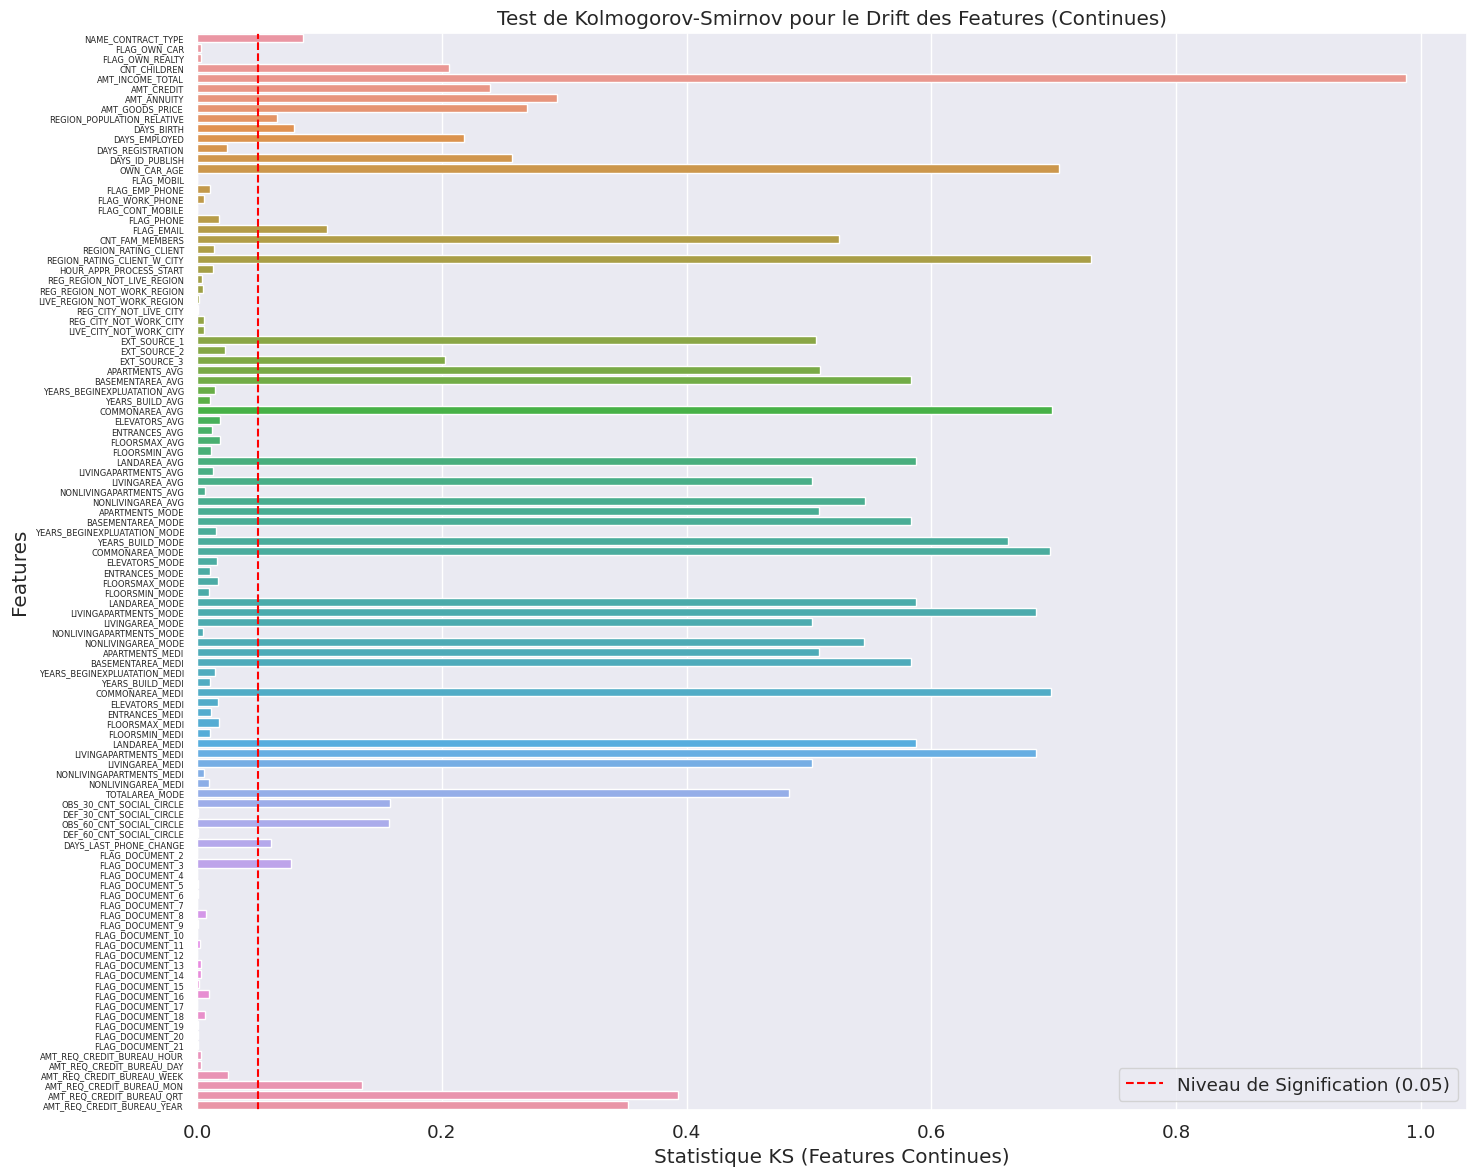

In [ ]:
# Sélectionner un sous-ensemble de labels à afficher
labels = train_dataset.select_dtypes(include=['float64']).columns

# Assurez-vous que ks_statistique_continues a la même longueur que labels
ks_statistique_continues = ks_statistique_continues[:len(labels)]

# Visualisation des résultats pour les features continues
plt.figure(figsize=(15, 12))
ax = sns.barplot(x=ks_statistique_continues, y=labels)
plt.axvline(alpha_continues, color='red', linestyle='--', label=f'Niveau de Signification ({alpha_continues})')
plt.xlabel('Statistique KS (Features Continues)')
plt.ylabel('Features')
plt.title('Test de Kolmogorov-Smirnov pour le Drift des Features (Continues)')
plt.legend()

# Réduire la taille du label de l'axe y
ax.set_yticklabels(train_dataset.select_dtypes(include=['float64']).columns, fontsize=6)

# Espacer les labels entre eux
plt.tight_layout()
plt.show()


In [ ]:
# Vérification des fonctionnalités en drift continues
fonctionnalités_continue_drift = [nom_feature for nom_feature, ks in zip(app_train_poly.select_dtypes(include=['float64']).columns, ks_statistique_continues) if ks > alpha_continues]

In [ ]:
if len(fonctionnalités_continue_drift) > 0:
    liste_verticale = [fonctionnalité + '\n' for fonctionnalité in fonctionnalités_continue_drift]
    print('Liste verticale :\n', ''.join(liste_verticale))
else:
    print("Aucun drift détecté dans les features continues.")

Liste verticale :
 AMT_INCOME_TOTAL
AMT_GOODS_PRICE
REGION_POPULATION_RELATIVE
DAYS_EMPLOYED
DAYS_REGISTRATION
OWN_CAR_AGE
CNT_FAM_MEMBERS
EXT_SOURCE_1_x
EXT_SOURCE_2_x
APARTMENTS_AVG
BASEMENTAREA_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LIVINGAPARTMENTS_AVG
COMMONAREA_MODE
ENTRANCES_MODE
FLOORSMAX_MODE
FLOORSMIN_MODE
LIVINGAREA_MODE
YEARS_BEGINEXPLUATATION_MEDI
COMMONAREA_MEDI
ENTRANCES_MEDI
FLOORSMAX_MEDI
FLOORSMIN_MEDI
LIVINGAPARTMENTS_MEDI
LIVINGAREA_MEDI
DEF_30_CNT_SOCIAL_CIRCLE
OBS_60_CNT_SOCIAL_CIRCLE
DEF_60_CNT_SOCIAL_CIRCLE
AMT_REQ_CREDIT_BUREAU_HOUR
AMT_REQ_CREDIT_BUREAU_DAY
AMT_REQ_CREDIT_BUREAU_WEEK
AMT_REQ_CREDIT_BUREAU_YEAR
DAYS_BIRTH_y
EXT_SOURCE_1^2
EXT_SOURCE_1 EXT_SOURCE_2
EXT_SOURCE_2^2
EXT_SOURCE_2 EXT_SOURCE_3
EXT_SOURCE_3^2
DAYS_BIRTH^2
EXT_SOURCE_1^2 EXT_SOURCE_2



In [ ]:
print('Nombre de drift détecté dans les features continues :', len(liste_verticale))

Nombre de drift détecté dans les features continues : 41


> ## Pour les features catégorielles

In [ ]:
# Calcul de l'indice de stabilité de la population (PSI) pour les features catégorielles
psi_catégoriques = []
for nom_de_feature in train_dataset.select_dtypes(include=['object']).columns:
    # Calcul des proportions dans les données d'entraînement et de test
    proportions_entrainement = train_dataset[nom_de_feature].value_counts(normalize=True).sort_index()
    proportions_test = test_dataset[nom_de_feature].value_counts(normalize=True).sort_index()

    # Calcul du PSI pour la fonctionnalité
    psi = np.sum((proportions_test - proportions_entrainement) * np.log(proportions_test / proportions_entrainement))
    psi_catégoriques.append(psi)

In [ ]:
psi_catégoriques

[]

>>>

In [ ]:
len(psi_catégoriques)

0

In [ ]:
len(labels)

107

In [ ]:
'''# Sélection des colonnes catégorielles
labels = train_dataset.select_dtypes(include=['object']).columns

# Visualisation des résultats pour les features catégorielles
plt.figure(figsize=(12, 6))

sns.barplot(y=labels, x=psi_catégoriques)  # Inverser les axes
plt.axvline(alpha_catégorique, color='red', linestyle='--', label=f'Niveau de Signification ({alpha_catégorique})')
plt.ylabel('PSI (Features Catégorielles)')  # Mettre à jour le label de l'axe Y
plt.xlabel('Features')  # Mettre à jour le label de l'axe X
plt.title("Indice de Stabilité de la Population (PSI) pour le Drift des Features (Catégorielles)")
plt.xticks(rotation=90)  # Faire pivoter les étiquettes de l'axe X pour une meilleure lisibilité
plt.legend()
plt.show()'''

'# Sélection des colonnes catégorielles\nlabels = train_dataset.select_dtypes(include=[\'object\']).columns\n\n# Visualisation des résultats pour les features catégorielles\nplt.figure(figsize=(12, 6))\n\nsns.barplot(y=labels, x=psi_catégoriques)  # Inverser les axes\nplt.axvline(alpha_catégorique, color=\'red\', linestyle=\'--\', label=f\'Niveau de Signification ({alpha_catégorique})\')\nplt.ylabel(\'PSI (Features Catégorielles)\')  # Mettre à jour le label de l\'axe Y\nplt.xlabel(\'Features\')  # Mettre à jour le label de l\'axe X\nplt.title("Indice de Stabilité de la Population (PSI) pour le Drift des Features (Catégorielles)")\nplt.xticks(rotation=90)  # Faire pivoter les étiquettes de l\'axe X pour une meilleure lisibilité\nplt.legend()\nplt.show()'

In [ ]:
# Vérification des fonctionnalités en drift catégorielles
fonctionnalités_catégorielles_drift = [nom_feature for nom_feature, psi in zip(app_train_poly.select_dtypes(include=['category']).columns, psi_catégoriques) if psi > alpha_catégorique]
fonctionnalités_catégorielles_drift

[]

In [ ]:
if len(fonctionnalités_catégorielles_drift) > 0:
    print("Attention : Drift détecté dans les fonctionnalités catégorielles :", fonctionnalités_catégorielles_drift)
else:
    print("Aucun drift détecté dans les fonctionnalités catégorielles.")

Aucun drift détecté dans les fonctionnalités catégorielles.


# Utilisation de l'API **MLflow** Python pour la gestion des expériences et des runs

In [ ]:
!pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.1 MB/s eta 0:00:00


In [ ]:
import mlflow
import mlflow.sklearn
import subprocess
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

import uuid

In [ ]:
# Arrêter l'exécution du MLflow
mlflow.end_run()

In [ ]:
# Vérification de l'exécution active dans MLflow et récupération de son ID
active_run = mlflow.active_run()

if active_run is not None:
    current_run_id = active_run.info.run_id
    # Utiliser current_run_id ou effectuer d'autres opérations avec l'exécution active
    print(f"ID de l'exécution active : {current_run_id}")
else:
    print("Aucune exécution active en cours dans MLflow.")


Aucune exécution active en cours dans MLflow.


In [ ]:
# Commencer une nouvelle exécution et obtenir l'ID de l'exécution active s'il en existe une
with mlflow.start_run() as run:
    # Récupérer l'ID de l'exécution en cours
    current_run_id = run.info.run_id

# Utilisation de l'ID de l'exécution pour référencer cette exécution
print(f"ID de l'exécution en cours : {current_run_id}")

ID de l'exécution en cours : 1a191cc624664270bc07b359e6c4c56b


> ## LightGBM

In [ ]:
# Entraîner le modèle à l'aide de RandomizedSearchCV
with mlflow.start_run():
    current_run_id_lgbm = mlflow.active_run().info.run_id

    # Faire des prédictions sur l'ensemble de tests
    y_pred = random_search_lgbm.predict(X_test)
    y_pred_proba = random_search_lgbm.predict_proba(X_test)[:, 1]

    # Calculer et loguer les métriques d'évaluation
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    mlflow.log_params(random_search_lgbm.best_params_)
    mlflow.log_metrics({
        "accuracy": accuracy,
        "f1_score": f1,
        "precision": precision,
        "recall": recall,
        "roc_auc": roc_auc,
    })

    # Loguer le modèle entraîné
    mlflow.sklearn.log_model(random_search_lgbm.best_estimator_, "lightGBM_model")

In [ ]:
# Récupérer les métriques de l'exécution spécifique
client = mlflow.tracking.MlflowClient()
metrics_lgbm = client.get_run(current_run_id_lgbm).data.metrics

# Afficher les métriques pour chaque modèle
print("Métriques du modèle LightGBM :")
for metric_name, metric_value in metrics_lgbm.items():
    print(f"{metric_name}: {metric_value}")

Métriques du modèle LightGBM :
recall: 0.6942816730652657
roc_auc: 0.7611439347825881
f1_score: 0.2689628180039139
accuracy: 0.6963074971952588
precision: 0.16678801999902917


In [ ]:
# Arrêter l'exécution du MLflow
mlflow.end_run()

> ## Regression logistique

corriger les parametres dans reglog où les paramètres des deux 2 modeles se melangent !

In [ ]:
# Entraîner le modèle à l'aide de RandomizedSearchCV
with mlflow.start_run():
    current_run_id_reglog = mlflow.active_run().info.run_id
    # Faire des prédictions sur l'ensemble de tests
    y_pred = random_search_regLog.predict(X_test)
    y_pred_proba = random_search_regLog.predict_proba(X_test)[:, 1]

    # Calculer et loguer les métriques d'évaluation
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    mlflow.log_params(random_search_regLog.best_params_)
    mlflow.log_metrics({
        "accuracy": accuracy,
        "f1_score": f1,
        "precision": precision,
        "recall": recall,
        "roc_auc": roc_auc,
    })

    # Loguer le modèle entraîné
    mlflow.sklearn.log_model(random_search_regLog.best_estimator_, "logistic_regression_model")

In [ ]:
# Récupérer les métriques de l'exécution spécifique
client = mlflow.tracking.MlflowClient()
metrics_reglog = client.get_run(current_run_id_reglog).data.metrics

print("\nMétriques du modèle de régression logistique :")
for metric_name, metric_value in metrics_reglog.items():
    print(f"{metric_name}: {metric_value}")


Métriques du modèle de régression logistique :
recall: 0.7839967670236412
roc_auc: 0.7466395841394509
f1_score: 0.22929409331324058
accuracy: 0.5759068663317236
precision: 0.13428393438084033


In [ ]:
# Arrêter l'exécution du MLflow
mlflow.end_run()

> ## Configuration et utilisation de NGROK pour la mise en place de tunnels/protocoles sécurisés

In [ ]:
!pip install pyngrok

In [ ]:
from pyngrok import ngrok

In [ ]:
# Configuration du jeton d'authentification pour ngrok
! ngrok authtoken 2ZWetlOSDkX4yeweNCOVNNI3q3B_5H5a6C9zakPhFRdvZUeRk

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok
from getpass import getpass

# Mettre fin aux protocoles ouverts s'ils existent
ngrok.kill()

# Définir l'authtoken (optionnel)
# Obtenez votre authtoken à partir de https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = getpass('Enter the ngrok authtoken: ')
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Ouvrir un protocole HTTPs sur le port 5000 pour http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

Enter the ngrok authtoken: ··········
MLflow Tracking UI: https://0286-34-16-149-170.ngrok-free.app


**My Authtoken** = 2ZWetlOSDkX4yeweNCOVNNI3q3B_5H5a6C9zakPhFRdvZUeRk

In [ ]:
# Démarrage de l'interface utilisateur MLflow
!mlflow ui --port 5000

[2023-12-17 16:28:53 +0000] [11314] [INFO] Starting gunicorn 21.2.0
[2023-12-17 16:28:53 +0000] [11314] [INFO] Listening at: http://127.0.0.1:5000 (11314)
[2023-12-17 16:28:53 +0000] [11314] [INFO] Using worker: sync
[2023-12-17 16:28:53 +0000] [11315] [INFO] Booting worker with pid: 11315
[2023-12-17 16:28:53 +0000] [11316] [INFO] Booting worker with pid: 11316
[2023-12-17 16:28:53 +0000] [11317] [INFO] Booting worker with pid: 11317
[2023-12-17 16:28:53 +0000] [11318] [INFO] Booting worker with pid: 11318


# Conclusions

Dans ce notebook, nous nous sommes d'abord assurés de bien comprendre les données. Ensuite, nous avons effectué une EDA assez simple pour essayer d'identifier les relations, les tendances ou les anomalies qui pourraient aider notre modélisation. En cours de route, nous avons effectué les étapes de prétraitement nécessaires, telles que le codage des variables catégorielles, l'imputation des valeurs manquantes et la mise à l'échelle des caractéristiques. Ensuite, nous avons construit de nouveaux features à partir des données existantes pour voir si cela pouvait aider notre modèle.

Une fois l'exploration des données, la préparation des données et l'ingénierie des caractéristiques terminées, nous avons mis en œuvre un modèle de base que nous espérons améliorer. Nous avons ensuite construit un deuxième modèle légèrement plus compliqué afin de battre notre premier score. Nous avons également réalisé une expérience pour déterminer l'effet de l'ajout de variables d'ingénierie.

Nous avons suivi le schéma général d'un [projet d'apprentissage automatique] (https://towardsdatascience.com/a-complete-machine-learning-walk-through-in-python-part-one-c62152f39420) :

1.  Comprendre le problème et les données
2. Nettoyage et formatage des données (cette tâche a été réalisée en grande partie par nos soins)
3. Analyse exploratoire des données
4. Modèle de référence
5.  Modèle amélioré
6. Interprétation du modèle (un peu)
